##### The University of Melbourne, School of Computing and Information Systems

**COMP30027 Machine Learning, 2022 Semester 1**

---

# **Assignment 2:** Sentiment Classification of Tweets

---

In [1]:
## Import all necessary modules for (Needed Installations Flagged):
# general use
import pandas as pd # INSTALL NEEDED
from collections import Counter, defaultdict
import numpy as np # INSTALL NEEDED
from scipy.sparse import csr_matrix, hstack, vstack # INSTALL NEEDED
from pprint import pprint # INSTALL NEEDED
import sklearn as skl # INSTALL NEEDED
import warnings
# plotting
import matplotlib.pyplot as plt # INSTALL NEEDED
from wordcloud import WordCloud # INSTALL NEEDED
# feature extraction
import re
from sklearn.feature_extraction import DictVectorizer # INSTALL NEEDED
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # INSTALL NEEDED
import nltk # INSTALL NEEDED
nltk.download('stopwords')
from nltk.corpus import stopwords, cmudict # INSTALL NEEDED
NLTK_STOPWORDS = list(stopwords.words())
NLTK_CMU = cmudict.dict()
from nltk.stem import PorterStemmer # INSTALL NEEDED
# import pronouncing # INSTALL NEEDED
# classifiers
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # INSTALL NEEDED
from sklearn.linear_model import LogisticRegression # INSTALL NEEDED
from sklearn.tree import DecisionTreeClassifier # INSTALL NEEDED
from sklearn.neighbors import KNeighborsClassifier # INSTALL NEEDED
from sklearn.svm import SVC, LinearSVC # INSTALL NEEDED
from sklearn.dummy import DummyClassifier # INSTALL NEEDED
# evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# set the plot font sizes
# ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 26
MEDIUM_SIZE = 30
BIGGER_SIZE = 34
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[nltk_data] Downloading package stopwords to C:\Users\Xavier
[nltk_data]     Travers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Raw Data Analysis

A shallow analysis of the dataset.

### Importing the data

In [2]:
train_df = pd.read_csv("../data/Train.csv", sep=',')
test_df = pd.read_csv("../data/Test.csv", sep=',')

### Basic Information
Specifically the types of the data and the lengths of each set.

In [3]:
# get information about types in the training set
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21802 entries, 0 to 21801
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  21802 non-null  int64 
 1   id          21802 non-null  int64 
 2   text        21802 non-null  object
 3   sentiment   21802 non-null  object
dtypes: int64(2), object(2)
memory usage: 681.4+ KB


In [4]:
# get information about types in the testing set
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6099 entries, 0 to 6098
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6099 non-null   int64 
 1   text    6099 non-null   object
dtypes: int64(1), object(1)
memory usage: 95.4+ KB


### Inspecting Instances 
To verify what they look like when `pandas` imports them.

In [5]:
# inspect the head of the training information
train_df.head()

Unnamed: 0                  id  \
0           2  805582613687713000   
1           3  637480203497832000   
2           4  641096279930507000   
3           5  625730917647126000   
4           6  633292370906230000   

                                                text sentiment  
0   doctors hit campaign trail as race to medical...   neutral  
1   is anybody going to the radio station tomorro...  positive  
2   i just found out naruto didn't become the 5th...   neutral  
3   "prince george reservist who died saturday ju...   neutral  
4   season in the sun versi nirvana rancak gak..s...  positive

In [6]:
# inspect the head of the testing information
test_df.head()

id                                               text
0  802217876644052000   @loogunda @poroshenko putin abducted ukrainia...
1  802425296955682000   if putin wanted to intervene all he would hav...
2  805664502515662000   @hillbuzz @gaypatriot elsewhere in progland.....
3  639928670103015000   any females copping the gucci foamposites tom...
4  673824182287904000   "in other news, had a great saturday on the t...

In [7]:
# show a random sample from the training information
train_df.sample(5)

Unnamed: 0                  id  \
13519       17347  640030272403083000   
18788       23924  639051612598747000   
2951         3768  632360490149281000   
12898       16540  629166655621328000   
6050         7699  640604094999187000   

                                                    text sentiment  
13519   "kanye west is running for president, but tha...   neutral  
18788  goin to the ed sheeran concert thursday and i ...   neutral  
2951    6th strike out by david price. love the calm ...  positive  
12898   "i got 3 options on friday   suck it up and w...  positive  
6050    @keandric hopefully you are having a great su...  positive

In [8]:
# show a random sample from the testing information
test_df.sample(5)

id                                               text
2120  639225541476880000   i'm pleased with my lord and islam is my deen...
469   634463428594241000   caitlyn jenner may be charged with vehicular ...
1421  674163596125937000   @gregjames hi greg. my daughter missed a call...
1149  677281899476291000   "mick jenkins may be the best rapper alive an...
2737  805668088364535000   simulation to show primary energy (fossil fue...

### Distribution of Sentiments

There may be a majority sentiment in the `Train.csv`.

Counter({'neutral': 12659, 'positive': 5428, 'negative': 3715})


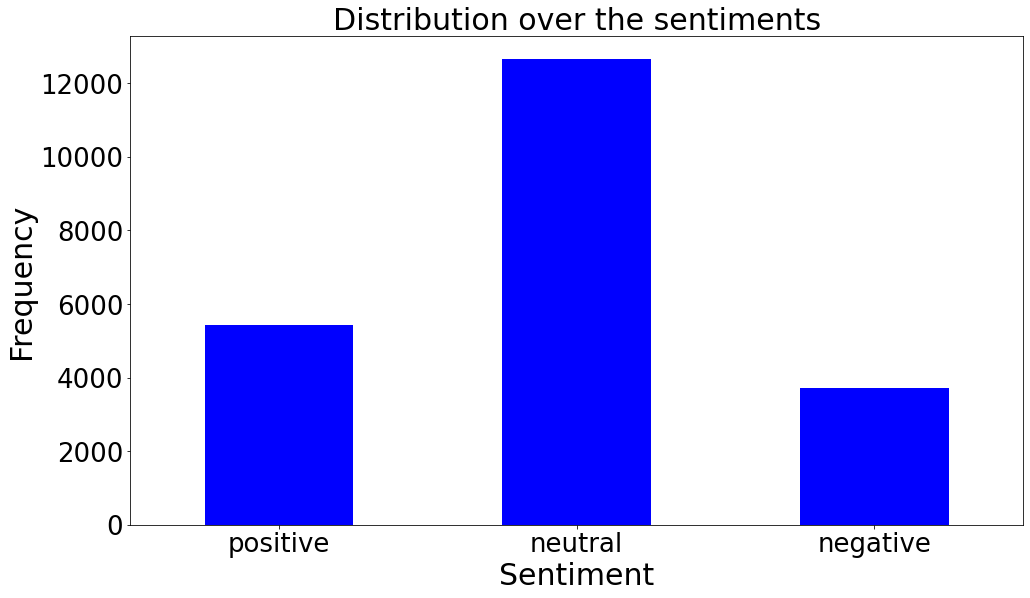

In [9]:
# Sentiment options and counts
print(Counter(train_df[['sentiment']].values[:, 0]))

# Distribution of the data between the sentiments
train_df.groupby('sentiment').count().sort_values('sentiment', ascending=False).plot.bar(
    legend=False, figsize=(16, 9), color='blue', rot=0)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution over the sentiments')
plt.savefig('../report/img/sentiment-distribution', bbox_inches='tight')

## 2. Data Preprocessing

Functionality for cleaning the text data

### Cleaning Functionality
A simple cleaning function for the data with modifiable features.

In [10]:
## pre-cache the regex
# common tweet feature regex
RE_LINKS = re.compile(r'https?://t.co/\w*')
RE_HASHTAGS = re.compile(r'(?<=\W)#\w*[a-z]\w*')
RE_MENTIONS = re.compile(r'(?<=\W)@\w+')
# other re
RE_REPEATED_CONSECUTIVES = re.compile(r'(.)\1+')
RE_NUMBERS = re.compile(r'\d+')
RE_NON_ALPHANUMERIC = re.compile(r'[^a-z]+')
RE_PUNCTUATION = re.compile(r'[\.?!,:;\-()\[\]{}"\'/]')

# list of different terms to clean
DEFAULT_CLEAN_DICT = {
    'links': True,
    'hashtags': True,
    'mentions': True,
    'numbers': True,
    'non-alphanumeric': True,
    'repeated-consecutive': True,
    'stopwords': None, # removing stopwords
}

# a function to selectively clean different terms within tweets
def clean_tweet(tweet: str, remove: dict = DEFAULT_CLEAN_DICT) -> str:
    new_tweet = tweet
    re_stopwords = ''
    if remove['stopwords'] is not None: 
        re_stopwords = re.compile(r'\b(' + r'|'.join(remove['stopwords']) + r')\b\s*')
    if remove['links']: new_tweet = RE_LINKS.sub(' ', new_tweet)
    if remove['hashtags']: new_tweet = RE_HASHTAGS.sub(' ', new_tweet)
    if remove['mentions']: new_tweet = RE_MENTIONS.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)
    if remove['repeated-consecutive']: new_tweet = RE_REPEATED_CONSECUTIVES.sub(r'\1\1', new_tweet)
    if remove['numbers']: new_tweet = RE_NUMBERS.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)
    if remove['non-alphanumeric']: 
        new_tweet = RE_NON_ALPHANUMERIC.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)

    # remove unnecessary space characters
    new_tweet = re.sub(r' +', ' ', new_tweet)
    new_tweet = re.sub(r'^ | $', '', new_tweet) # bookend spaces
    return new_tweet

# apply the default cleaning function to the training and test sets
train_df['text-clean-no-stopwords'] = train_df['text'].apply(clean_tweet)
test_df['text-clean-no-stopwords'] = test_df['text'].apply(clean_tweet)

# inspect a sample of the training information and compare the clean and raw tweets
train_df.sample(5)

Unnamed: 0                  id  \
14100       18090  665949616152698000   
20223       25814  805648943723868000   
20161       25735  802149662891200000   
17695       22546  802188679099907000   
7111         9053  639778929205620000   

                                                    text sentiment  \
14100   @bettenkr this one is from the charlie hebdo ...   neutral   
20223  ‚äúa prohibition of refugees won't prevent ter...   neutral   
20161  lopetegui (coach spain): "for the best fifa me...  positive   
17695   good morning everyone except dakota access pi...   neutral   
7111    gucci bags ego ideal profound secret february...   neutral   

                                 text-clean-no-stopwords  
14100  this one is from the charlie hebdo but may giv...  
20223  a prohibition of refugees won t prevent terror...  
20161  lopetegui coach spain for the best fifa men s ...  
17695  good morning everyone except dakota access pip...  
7111   gucci bags ego ideal profound secret february ...

### Identifying Stopwords
Words with little value to be removed

In [11]:
# start the wordcloud object here
wc = WordCloud(max_words=750, width=1920, height=1080)

# a function to display and save a named word cloud
def show_save_word_cloud(text, filename):
    cloud = wc.generate(text)
    plt.figure(figsize= (16, 9), frameon=False)
    plt.axis('off')
    print(f'Word cloud for {filename}')
    plt.imshow(cloud)
    plt.savefig(f'../report/img/wc/{filename}', bbox_inches='tight')

# show and save the wc for train, test, all
if False: # this code hangs sometimes, so change this to run it again
    # show_save_word_cloud(" ".join(train_df['text-clean-default']), 'train-clean-default')
    # show_save_word_cloud(" ".join(test_df['text-clean-default']), 'test-clean-default')
    show_save_word_cloud(" ".join(train_df['text-clean-no-stopwords']) + " " + " ".join(test_df['text-clean-no-stopwords']), 
        'text-clean-no-stopwords')

    # generate the wc for `positive`, `neutral` and `negative` instances only
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df['text-clean-no-stopwords']),
        f'{sentiment}-clean-no-stopwords')

Word cloud for all-clean-nltk
Word cloud for negative-clean-nltk
Word cloud for positive-clean-nltk
Word cloud for neutral-clean-nltk
Word cloud for all-clean-final
Word cloud for negative-clean-final
Word cloud for positive-clean-final
Word cloud for neutral-clean-final


Unnamed: 0                  id  \
14676       18840  802130411505810000   
20949       26794  640194736775659000   
14668       18829  802280439524245000   
11675       14941  666381486879326000   
1436         1846  679527950811840000   

                                                    text sentiment  \
14676   drill baby drill... and devaluate? #libya #me...   neutral   
20949  we should condemn sunday oliseh pls. he is not...  negative   
14668   fun fact. my iud would have cost $1422 w/o ob...  positive   
11675   i watched the big bang theory on thursday whe...  positive   
1436    kendrick lamar with big sean - alright (live)...  positive   

                                 text-clean-no-stopwords  \
14676                     drill baby drill and devaluate   
20949  we should condemn sunday oliseh pls he is not ...   
14668  fun fact my iud would have cost w o obamacare ...   
11675  i watched the big bang theory on thursday when...   
1436   kendrick lamar with big sean alright live nd a...   

                                         text-clean-nltk  \
14676                         drill baby drill devaluate   
20949  condemn sunday oliseh pls messiah super eagles...   
14668  fun fact iud would cost w obamacare b obamacar...   
11675  watched big bang theory thursday home cannot g...   
1436   kendrick lamar big alright live nd annual tde ...   

                                              text-clean  
14676                         drill baby drill devaluate  
20949  condemn sunday oliseh pls messiah super eagles...  
14668  fun fact iud would cost w obamacare b obamacar...  
11675  watched big bang theory thursday home cannot g...  
1436   kendrick lamar big alright live nd annual tde ...

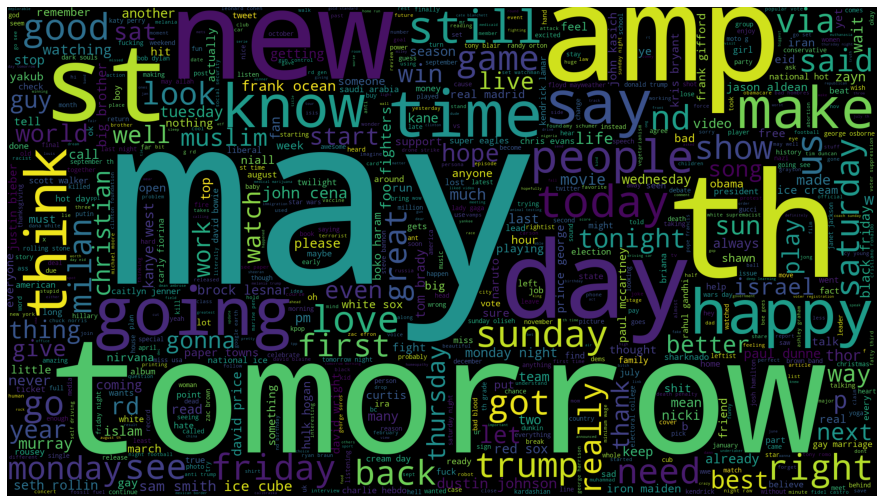

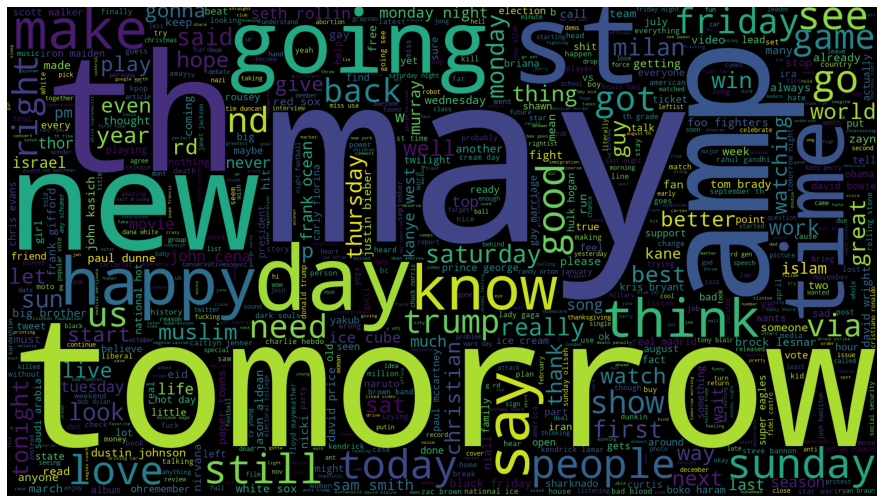

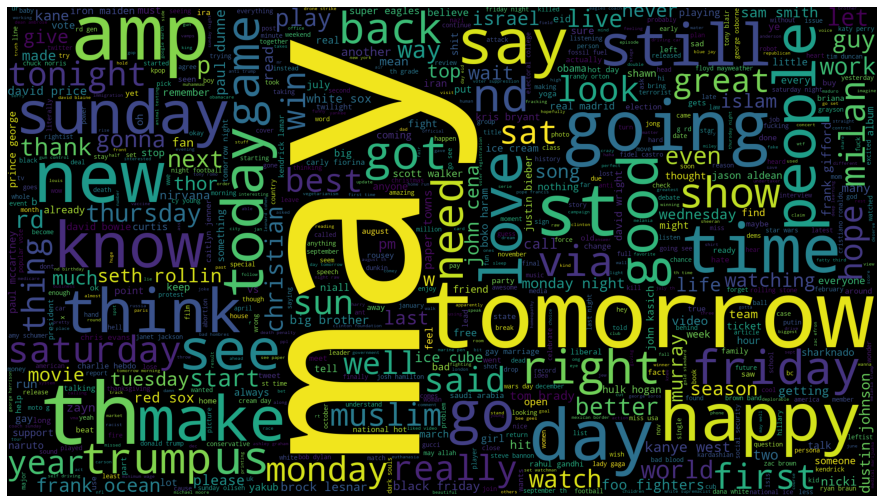

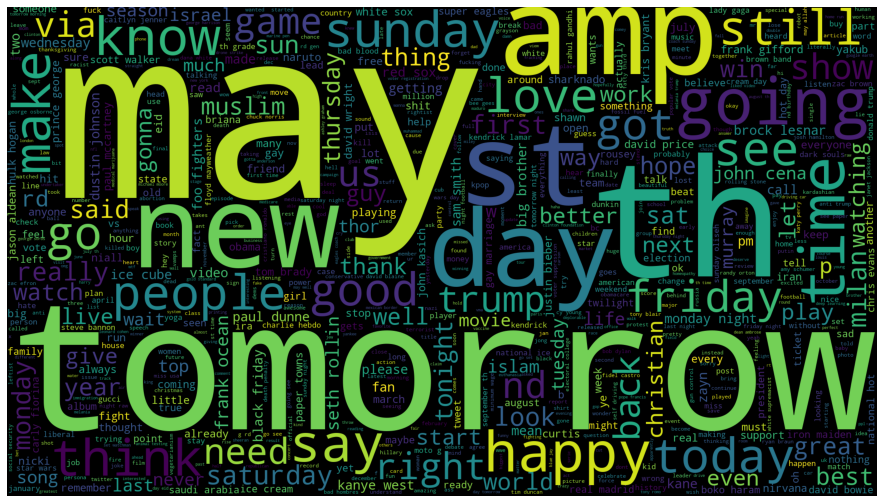

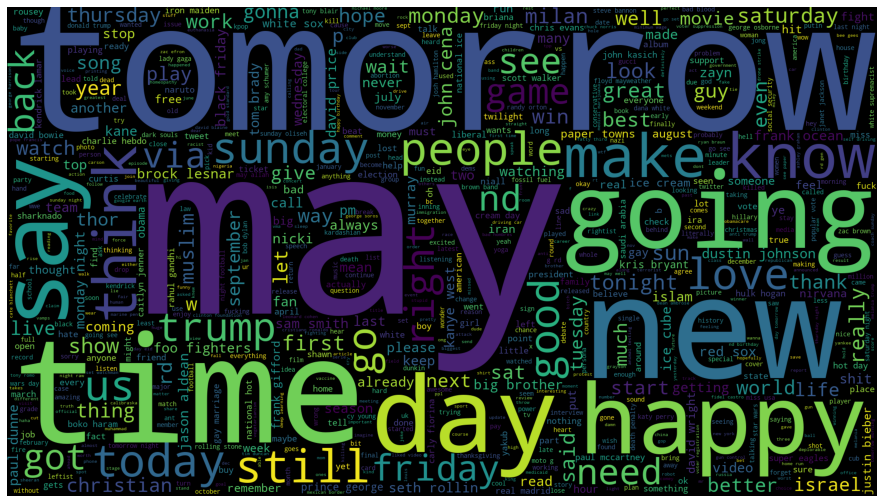

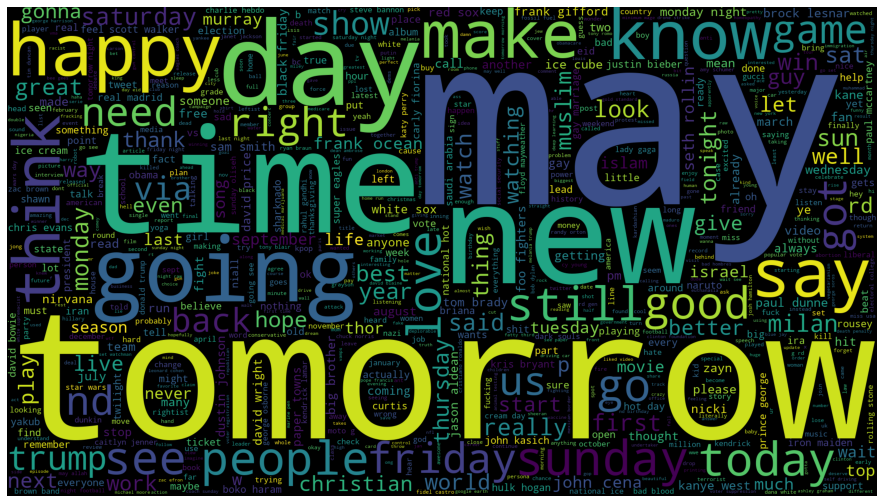

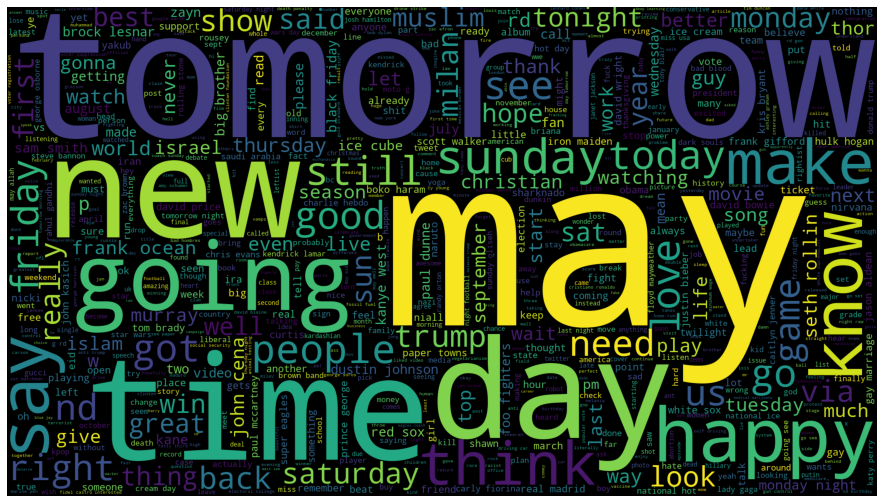

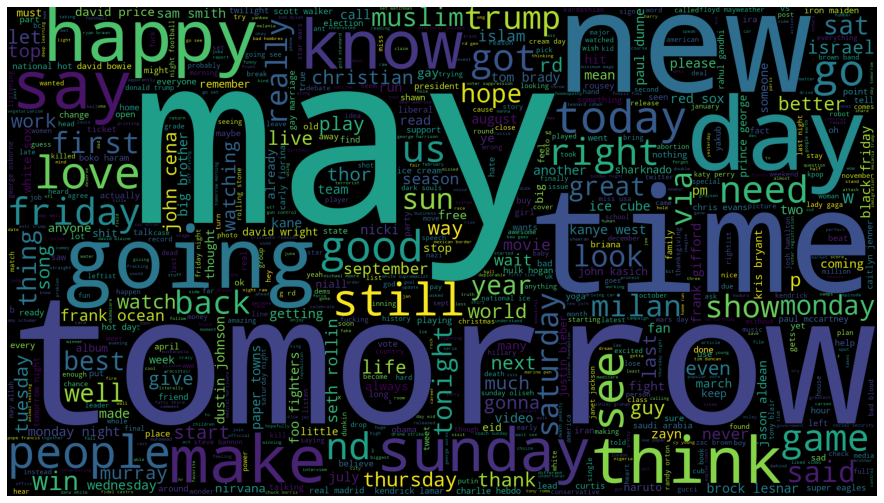

In [45]:
# NLTK's stopword list is most applicable (+ add stuff from re-analysis)
FINAL_STOPWORDS = ['amp', 'th', 'st'] + NLTK_STOPWORDS

# apply the cleaning with the different stopword lists
cleanConfig = DEFAULT_CLEAN_DICT.copy()
cleanConfig['stopwords'] = NLTK_STOPWORDS
train_df['text-clean-nltk'] = train_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
test_df['text-clean-nltk'] = test_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
cleanConfig['stopwords'] = FINAL_STOPWORDS
train_df['text-clean'] = train_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
test_df['text-clean'] = test_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))

FINAL_CLEAN_CONFIG = cleanConfig

# generate the wc for the nltk cleaned all, `positive`, `neutral` and `negative` instances
if True: # this code hangs sometimes, so change this to run it again
    show_save_word_cloud(" ".join(train_df['text-clean-nltk']) + " " + " ".join(test_df['text-clean-nltk']), 
        'all-clean-nltk')
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df['text-clean-nltk']),
        f'{sentiment}-clean-nltk')

    # generate the wc for the nltk cleaned all, `positive`, `neutral` and `negative` instances
    show_save_word_cloud(" ".join(train_df['text-clean']) + " " + " ".join(test_df['text-clean']), 
        'all-clean-final')
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df['text-clean']),
        f'{sentiment}-clean-final')

# compare the differences
train_df.sample(5)

## 3. Vectorizers
Three transformers are going to be used `TfidfVectorizer`, `CountVectorizer` and `DictVectorizer`.
The following is code to compare the different features produced on a bar graph (showing those most influential).

In [46]:
# define the colours for the different sentiment sets
SENTIMENT_COLOURS = {
    'all': 'orange',
    'positive': 'green',
    'neutral': 'blue',
    'negative': 'red'
}

# create a bar graph (and save it)
def show_save_bar_graph(plot, X:csr_matrix, y: list[str], features: list[str], 
        feature_type: str, sentiment: str, sort_type: str='relative', 
        max_features: int|None=10, labels=False, save=False):

    # ensure the max features are not higher than the length
    if max_features > len(features) or max_features == None: 
        max_features = len(features)
    # fill the value list for the bars
    values = np.zeros((len(features)))
    sums = np.zeros((len(features)))
    for idx, f in enumerate(features):
        all_entries = X[:, idx]
        s_entries = all_entries[y == sentiment]
        sums[idx] = np.sum(all_entries)
        if sentiment == 'all': 
            values[idx] = np.sum(all_entries) / len(y)
        elif sort_type == 'relative':
            values[idx] = np.sum(s_entries) / np.sum(all_entries)
        else:
            values[idx] = np.sum(s_entries) / len(y[y == sentiment])
    values_sums_names = sorted(zip(values, sums, features), reverse=True)[:max_features]
    values = [vn[0] for vn in values_sums_names]
    features = [vn[2] for vn in values_sums_names]
    plot.bar(range(max_features), values, color=SENTIMENT_COLOURS[sentiment])
    if labels:
        plot.xlabel(f'Top {max_features} Features',) 
        plot.ylabel(f'{sort_type} Value',) 
    plot.set_xticks(range(max_features))
    plot.set_xticklabels(features, rotation=45, ha='right')
    plot.set_title(f'{sentiment.upper()} {feature_type} Bar Graph')
    if save:
        plt.savefig(f'../report/img/bar/{sentiment}', bbox_inches='tight')


# create a method to generate 4 bar graphs for top features in a vector based on their relative sums
def compare_bars(X, y, features, feature_type: str, sort_type: str='relative', max_features: int|None=10):

    if max_features > len(features): max_features = len(features)
    f, axes = plt.subplots(1, 4)
    f.set_size_inches([32, 12])

    # set the labels
    f.supxlabel(f'Top {max_features} Features', va='baseline')
    f.supylabel(f'{sort_type.upper()} Value')
    f.suptitle(f'Comparing {feature_type} across sentiments')
    f.subplots_adjust(bottom=0.25, wspace=0.3)

    show_save_bar_graph(axes[0], X, y, features, '-', 'all', sort_type, max_features)

    for idx, sentiment in enumerate(['positive', 'neutral', 'negative']):
        show_save_bar_graph(axes[idx+1], X, y, features, '-', sentiment, sort_type, max_features)

    plt.savefig(f'../report/img/bar/compare-{feature_type}', bbox_inches='tight')


## 4. Tokenization

Implementing different forms of token/vector generation.

In [47]:
# define the X dictionaries and y for the sentiments
X_train_features = dict()
X_test_features = dict()
y = train_df['sentiment']

# for the sake of comparison/testing, set the # of max features to smth low
MAX_FEATURES = 10000
USE_BINARY = False
USE_TFIDF = False

### Words

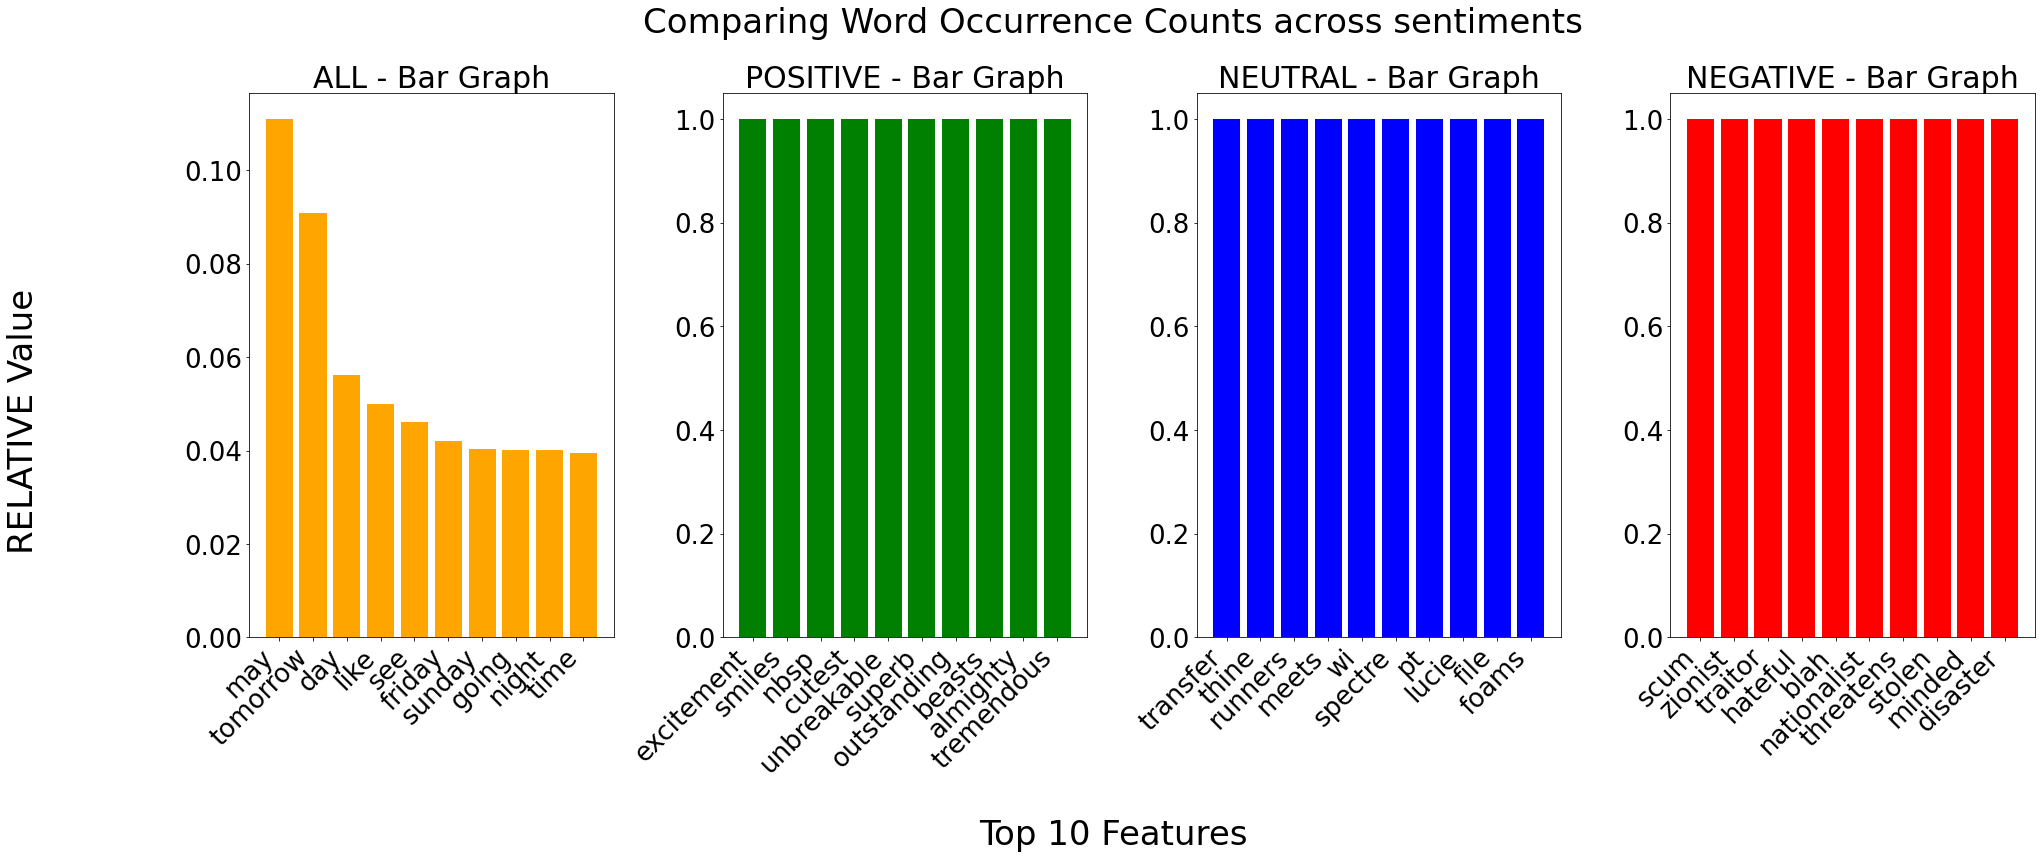

In [48]:
# test the regular word split tokenization on the count/bag-of-words
FEATURE_WORDS_COUNT = 'Word Occurrence Counts'
cv_w = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY)
X_train_features[FEATURE_WORDS_COUNT] = cv_w.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORDS_COUNT] = cv_w.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORDS_COUNT], y, cv_w.get_feature_names_out(), FEATURE_WORDS_COUNT)

if USE_TFIDF:
    # test the regular word split tokenization on the tf-idf
    FEATURE_WORDS_TFIDF = 'TF-IDF of Words'
    tfidf_w = TfidfVectorizer(max_features=MAX_FEATURES)
    X_train_features[FEATURE_WORDS_TFIDF] = tfidf_w.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_WORDS_TFIDF] = tfidf_w.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_WORDS_TFIDF], y, tfidf_w.get_feature_names_out(), FEATURE_WORDS_TFIDF)

### Part-of-speech Tags

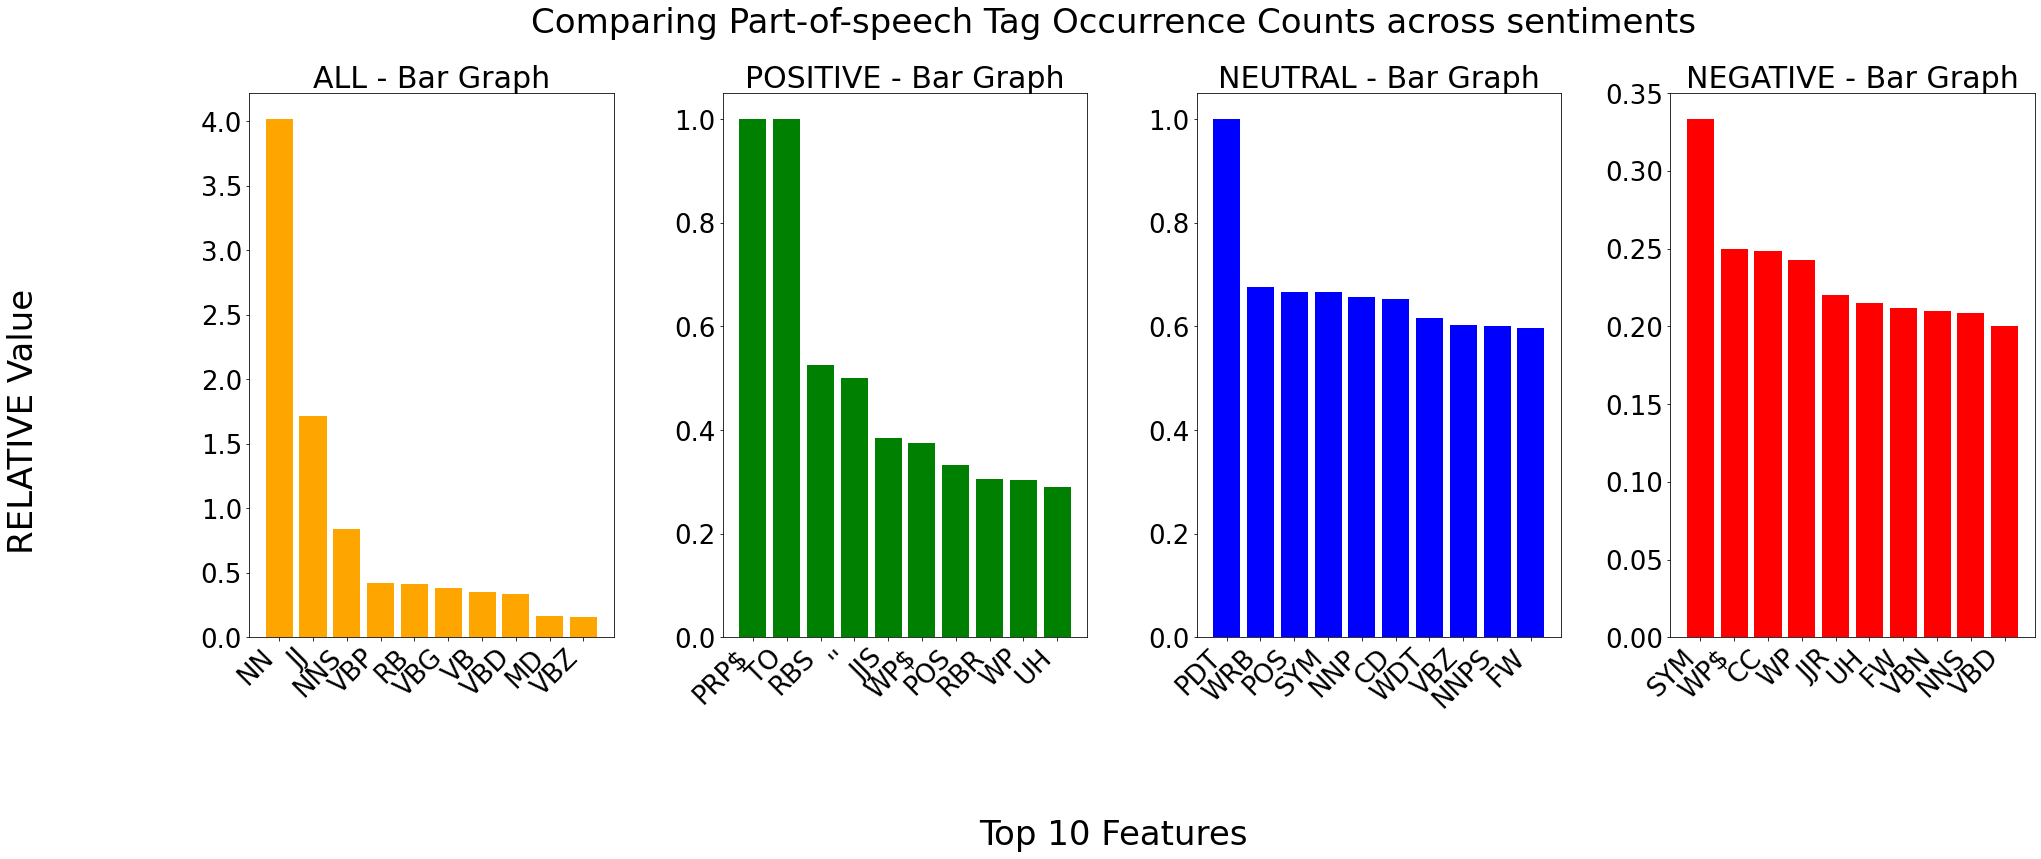

In [49]:
# Define the tags list
def tokenizer_pos(tweet): return [t[1] for t in nltk.pos_tag(tweet.split(' '))]

# test the stemming split tokenization on the count/bag-of-words
FEATURE_POS_TAGS_COUNT = 'Part-of-speech Tag Occurrence Counts'
cv_pos = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_pos)
X_train_features[FEATURE_POS_TAGS_COUNT] = cv_pos.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_POS_TAGS_COUNT] = cv_pos.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_POS_TAGS_COUNT], y, cv_pos.get_feature_names_out(), FEATURE_POS_TAGS_COUNT)

if USE_TFIDF:
    # test the stemming split tokenization on the tf-idf
    FEATURE_POS_TAGS_TFIDF = 'TF-IDF of Part-of-speech Tags'
    tfidf_pos = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_pos)
    X_train_features[FEATURE_POS_TAGS_TFIDF] = tfidf_pos.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_POS_TAGS_TFIDF] = tfidf_pos.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_POS_TAGS_TFIDF], y, tfidf_pos.get_feature_names_out(), FEATURE_POS_TAGS_TFIDF)

### Stems

In [50]:
if False: # stemming not needed
    # Porter Stemmer
    ps = PorterStemmer()
    def tokenizer_stem(tweet): return [ps.stem(w) for w in tweet.split(' ')]

    # test the stemming split tokenization on the count/bag-of-words
    FEATURE_STEMS_COUNT = 'English Stemmed Word Occurrence Counts'
    cv_ps = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_stem)
    X_train_features[FEATURE_STEMS_COUNT] = cv_ps.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_STEMS_COUNT] = cv_ps.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_STEMS_COUNT], y, cv_ps.get_feature_names_out(), FEATURE_STEMS_COUNT)

    if USE_TFIDF:
        # test the stemming split tokenization on the tf-idf
        FEATURE_STEMS_TFIDF = 'TF-IDF of English Stemmed Words'
        tfidf_ps = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_stem)
        X_train_features[FEATURE_STEMS_TFIDF] = tfidf_ps.fit_transform(train_df['text-clean'])
        X_test_features[FEATURE_STEMS_TFIDF] = tfidf_ps.transform(test_df['text-clean'])
        compare_bars(X_train_features[FEATURE_STEMS_TFIDF], y, tfidf_ps.get_feature_names_out(), FEATURE_STEMS_TFIDF)

### 2-Grams

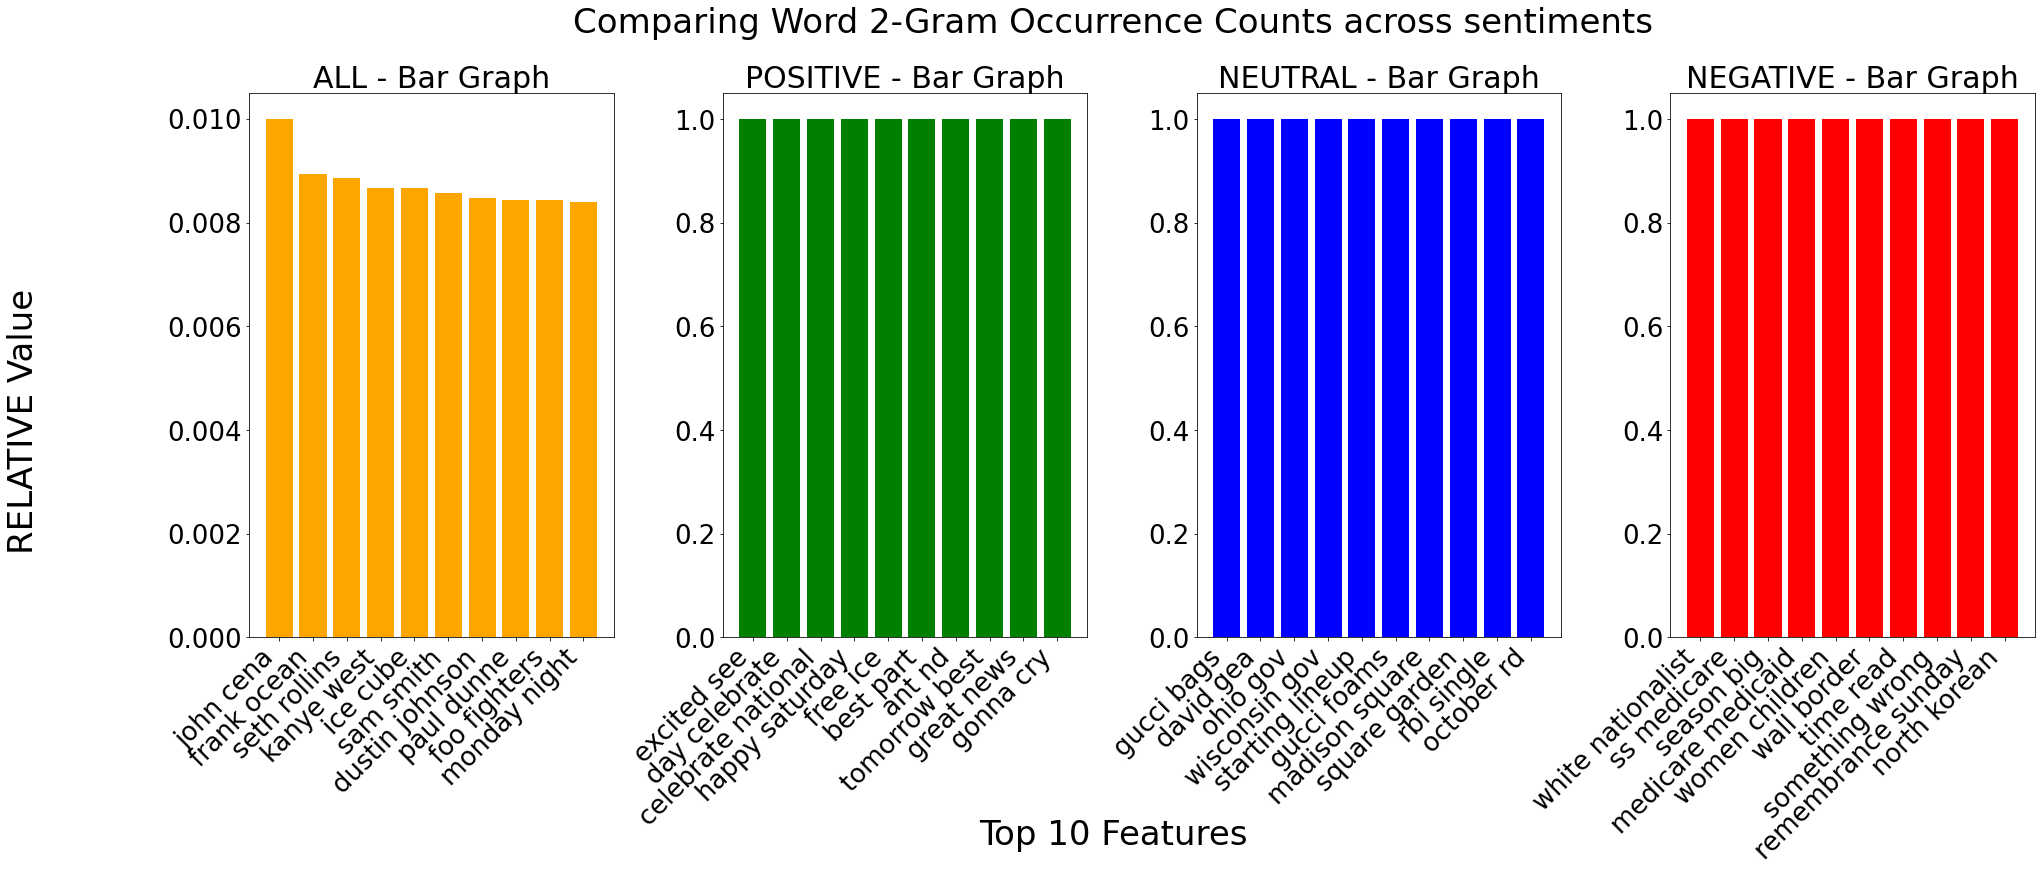

In [51]:
# Test on occurrences
FEATURE_WORD_2GRAMS_COUNT = 'Word 2-Gram Occurrence Counts'
cv_word2g = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, ngram_range=(2, 2))
X_train_features[FEATURE_WORD_2GRAMS_COUNT] = cv_word2g.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORD_2GRAMS_COUNT] = cv_word2g.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORD_2GRAMS_COUNT], y, cv_word2g.get_feature_names_out(), FEATURE_WORD_2GRAMS_COUNT)

if USE_TFIDF:
    # Test on tfidf
    FEATURE_WORD_2GRAMS_TFIDF = 'TF-IDF of Word 2-Grams'
    tfidf_word2g = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2))
    X_train_features[FEATURE_WORD_2GRAMS_TFIDF] = tfidf_word2g.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_WORD_2GRAMS_TFIDF] = tfidf_word2g.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_WORD_2GRAMS_TFIDF], y, tfidf_word2g.get_feature_names_out(), FEATURE_WORD_2GRAMS_TFIDF)

if False: # stemming not needed
    # tokenizer by stemming instead
    # Test on occurrences
    FEATURE_STEM_2GRAMS_COUNT = 'English Stemmed 2-Gram Occurrence Counts'
    cv_stem2g = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, ngram_range=(2, 2), tokenizer=tokenizer_stem)
    X_train_features[FEATURE_STEM_2GRAMS_COUNT] = cv_stem2g.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_STEM_2GRAMS_COUNT] = cv_stem2g.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_STEM_2GRAMS_COUNT], y, cv_stem2g.get_feature_names_out(), FEATURE_STEM_2GRAMS_COUNT)

    if USE_TFIDF:
        # Test on tfidf
        FEATURE_STEM_2GRAMS_TFIDF = 'TF-IDF of English Stemmed 2-Grams'
        tfidf_stem2g = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2), tokenizer=tokenizer_stem)
        X_train_features[FEATURE_STEM_2GRAMS_TFIDF] = tfidf_stem2g.fit_transform(train_df['text-clean'])
        X_test_features[FEATURE_STEM_2GRAMS_TFIDF] = tfidf_stem2g.transform(test_df['text-clean'])
        compare_bars(X_train_features[FEATURE_STEM_2GRAMS_TFIDF], y, tfidf_stem2g.get_feature_names_out(), FEATURE_STEM_2GRAMS_TFIDF)

### Characters

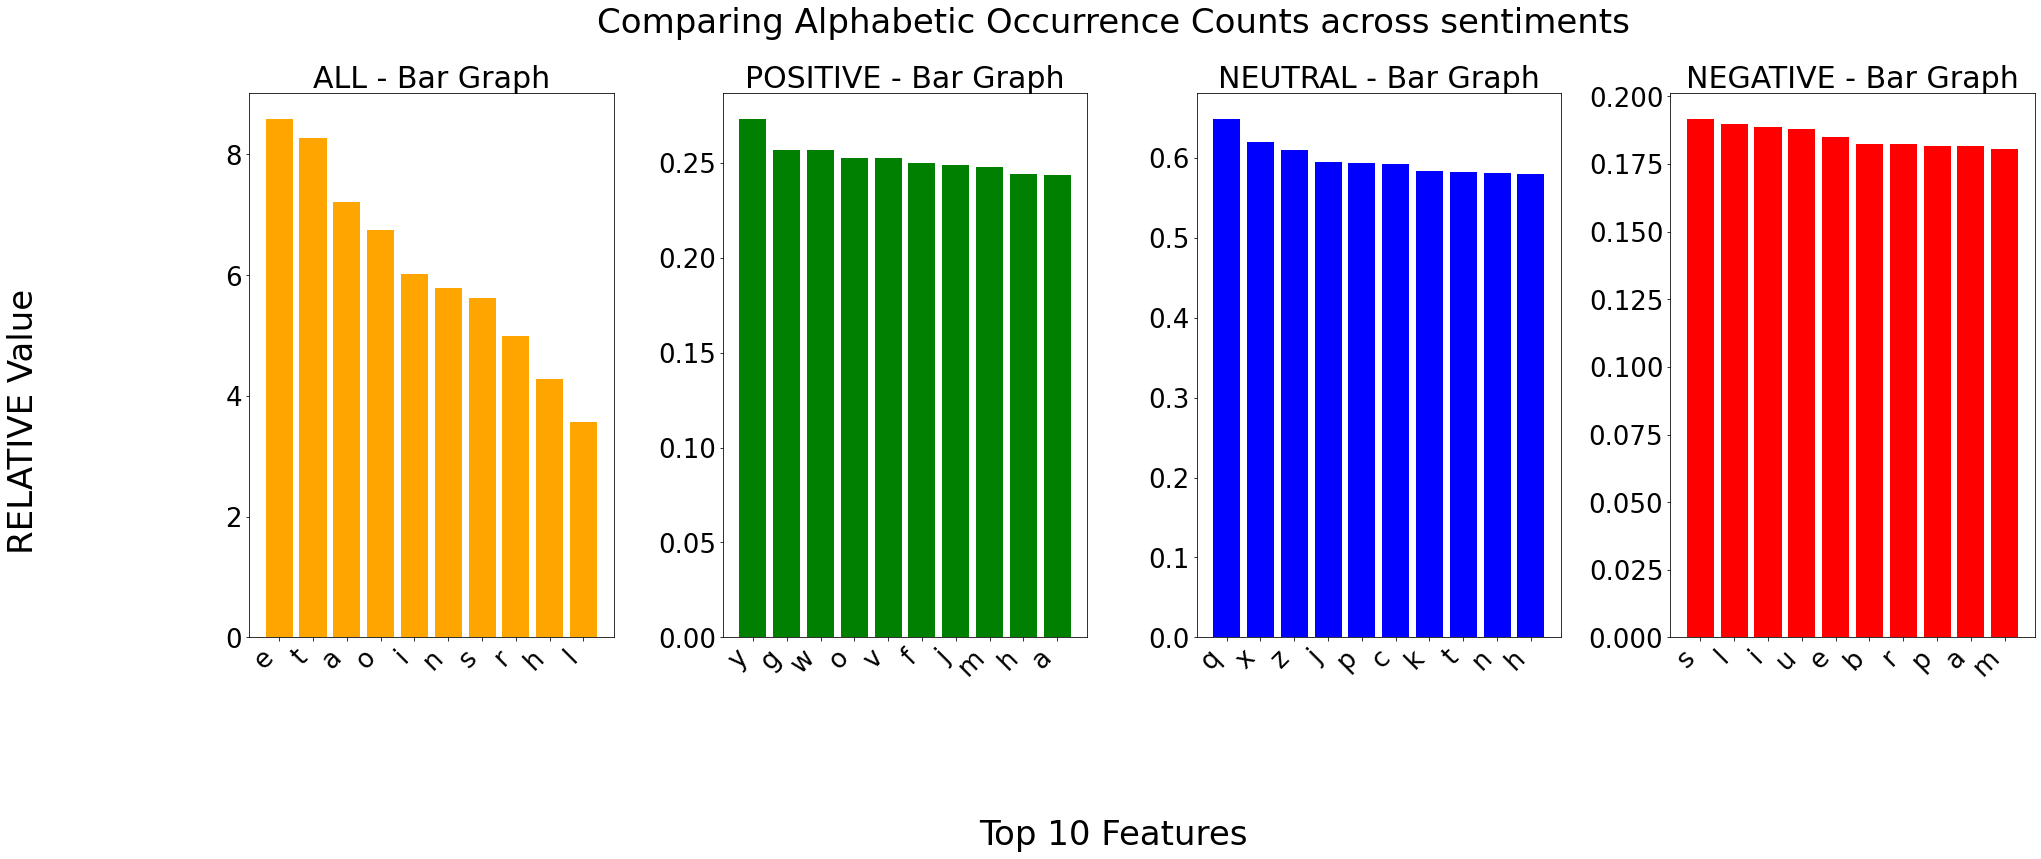

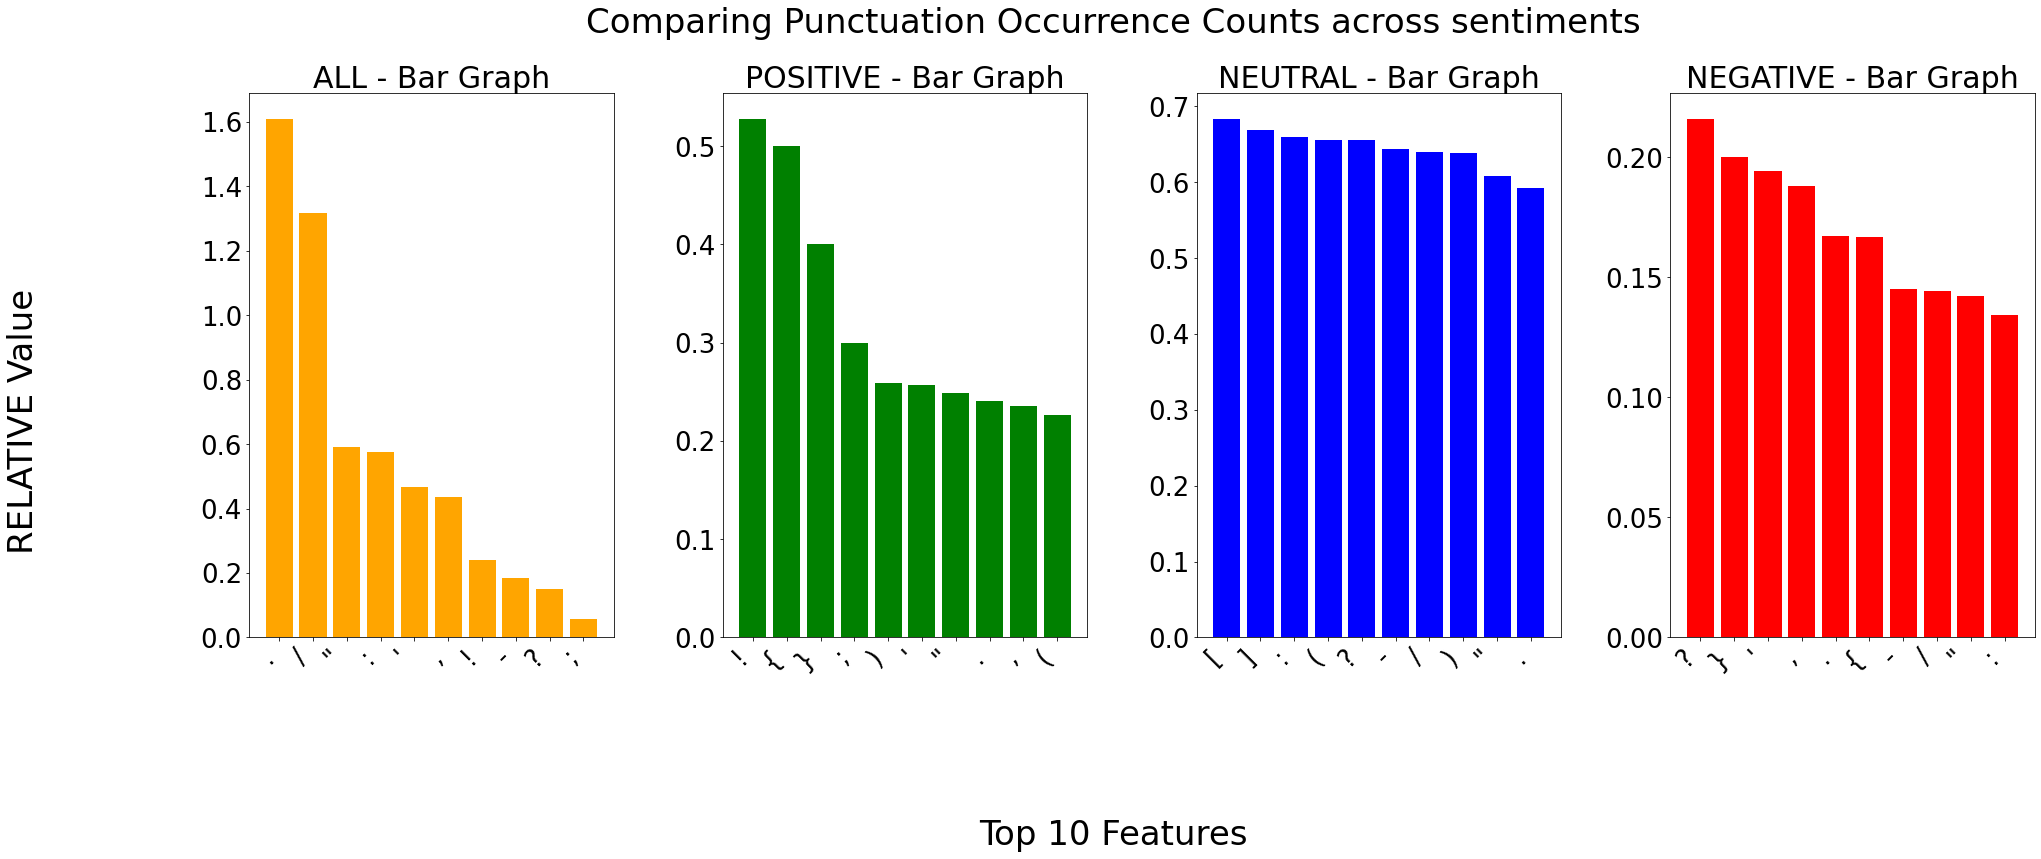

In [52]:
def tokenizer_char(tweet, char_type = 'alphabetic'): 
    if char_type == 'alphabetic':
        t = re.sub(r'[^a-z]+', '', tweet)
        return list(t)
    elif char_type == 'non-word':
        t = re.sub(r'[\w\s]+', '', tweet)
        return list(t)
    elif char_type == 'punctuation':
        return RE_PUNCTUATION.findall(tweet)
    else:
        return list(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_ALPHABETICS_COUNT = 'Alphabetic Occurrence Counts'
cv_alpha = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_char)
X_train_features[FEATURE_ALPHABETICS_COUNT] = cv_alpha.fit_transform(train_df['text'])
X_test_features[FEATURE_ALPHABETICS_COUNT] = cv_alpha.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_ALPHABETICS_COUNT], y, cv_alpha.get_feature_names_out(), FEATURE_ALPHABETICS_COUNT)

if USE_TFIDF:
    # test the regular word split tokenization on the tf-idf
    FEATURE_ALPHABETICS_TFIDF = 'TF-IDF of Alphabetics'
    tfidf_alpha = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_char)
    X_train_features[FEATURE_ALPHABETICS_TFIDF] = tfidf_alpha.fit_transform(train_df['text'])
    X_test_features[FEATURE_ALPHABETICS_TFIDF] = tfidf_alpha.transform(test_df['text'])
    compare_bars(X_train_features[FEATURE_ALPHABETICS_TFIDF], y, tfidf_alpha.get_feature_names_out(), FEATURE_ALPHABETICS_TFIDF)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_PUNCTUATION_COUNT = 'Punctuation Occurrence Counts'
cv_punct = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=lambda t: tokenizer_char(t, 'punctuation'))
X_train_features[FEATURE_PUNCTUATION_COUNT] = cv_punct.fit_transform(train_df['text'])
X_test_features[FEATURE_PUNCTUATION_COUNT] = cv_punct.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_PUNCTUATION_COUNT], y, cv_punct.get_feature_names_out(), FEATURE_PUNCTUATION_COUNT)

if USE_TFIDF:
    # test the regular word split tokenization on the tf-idf
    FEATURE_PUNCTUATION_TFIDF = 'TF-IDF of Punctuation'
    tfidf_punct = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_char(t, 'punctuation'))
    X_train_features[FEATURE_PUNCTUATION_TFIDF] = tfidf_punct.fit_transform(train_df['text'])
    X_test_features[FEATURE_PUNCTUATION_TFIDF] = tfidf_punct.transform(test_df['text'])
    compare_bars(X_train_features[FEATURE_PUNCTUATION_TFIDF], y, tfidf_punct.get_feature_names_out(), FEATURE_PUNCTUATION_TFIDF)

### Word Lengths

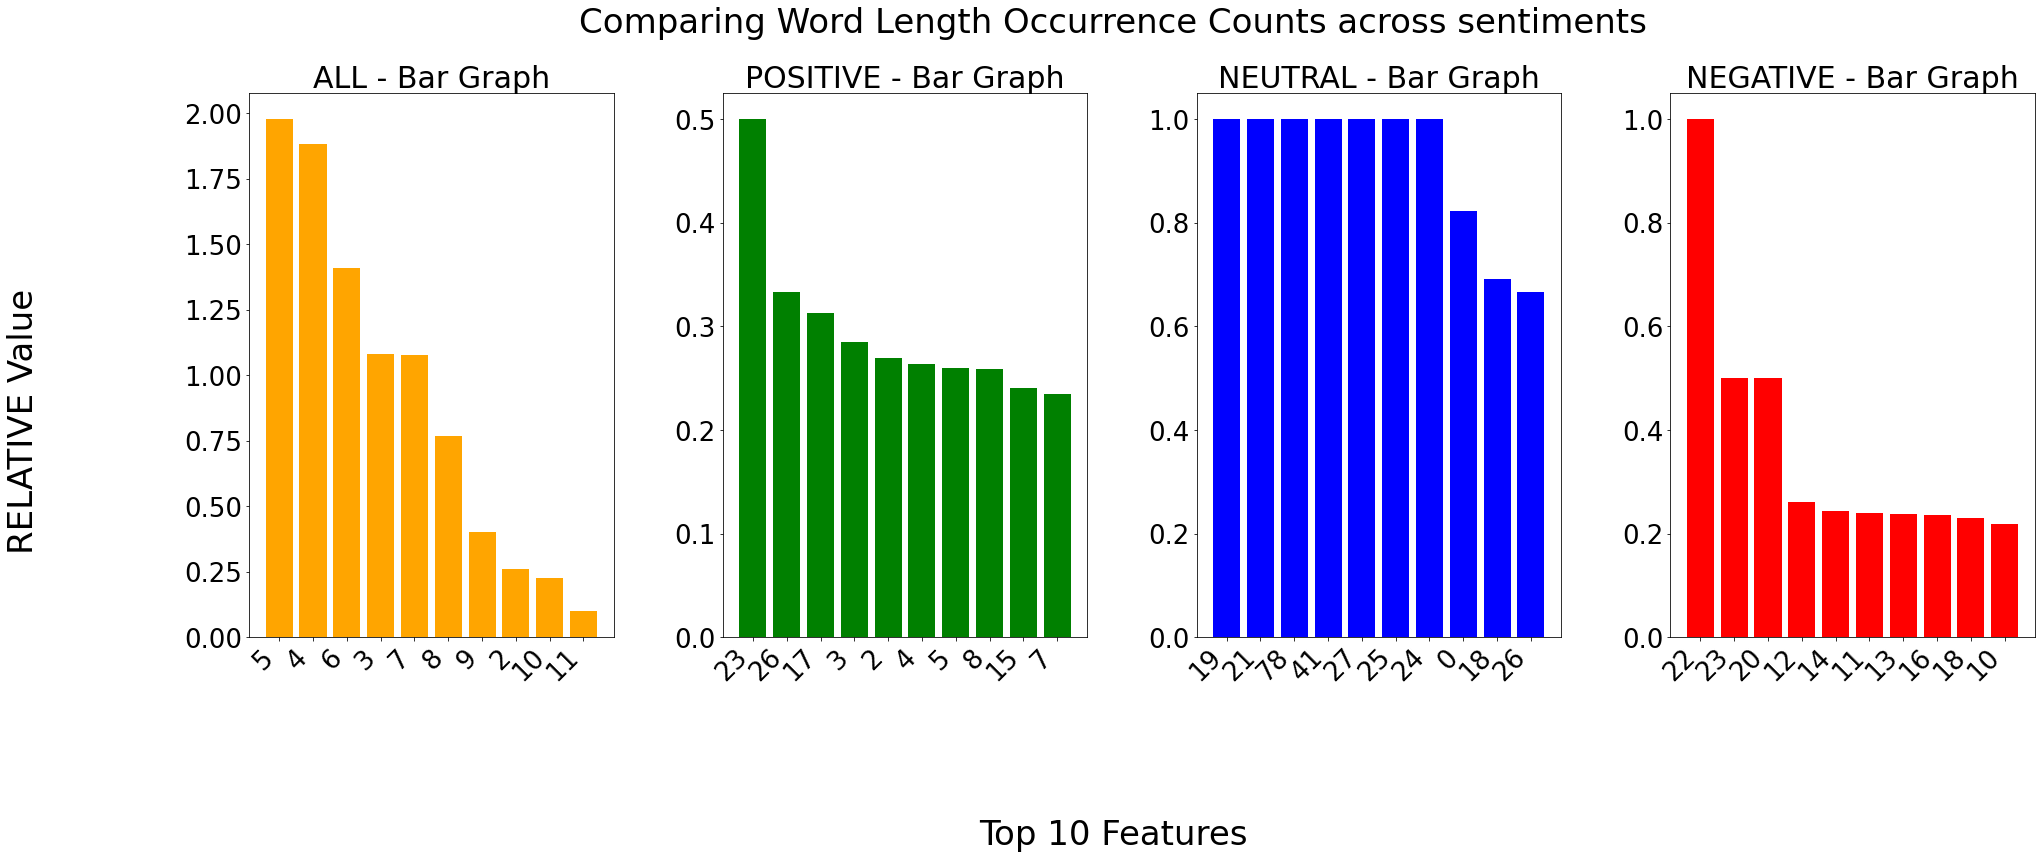

In [53]:
def tokenizer_word_lengths(tweet): return [f'{len(w)}' for w in tweet.split(' ')]

# test the regular word split tokenization on the count/bag-of-words
FEATURE_WORD_LENGTHS_COUNT = 'Word Length Occurrence Counts'
cv_wl = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_word_lengths)
X_train_features[FEATURE_WORD_LENGTHS_COUNT] = cv_wl.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORD_LENGTHS_COUNT] = cv_wl.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORD_LENGTHS_COUNT], y, cv_wl.get_feature_names_out(), FEATURE_WORD_LENGTHS_COUNT)

if USE_TFIDF:
    # test the regular word split tokenization on the tf-idf
    FEATURE_WORD_LENGTHS_TFIDF = 'TF-IDF of Word Lengths'
    tfidf_wl = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_word_lengths)
    X_train_features[FEATURE_WORD_LENGTHS_TFIDF] = tfidf_wl.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_WORD_LENGTHS_TFIDF] = tfidf_wl.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_WORD_LENGTHS_TFIDF], y, tfidf_wl.get_feature_names_out(), FEATURE_WORD_LENGTHS_TFIDF)

### Links

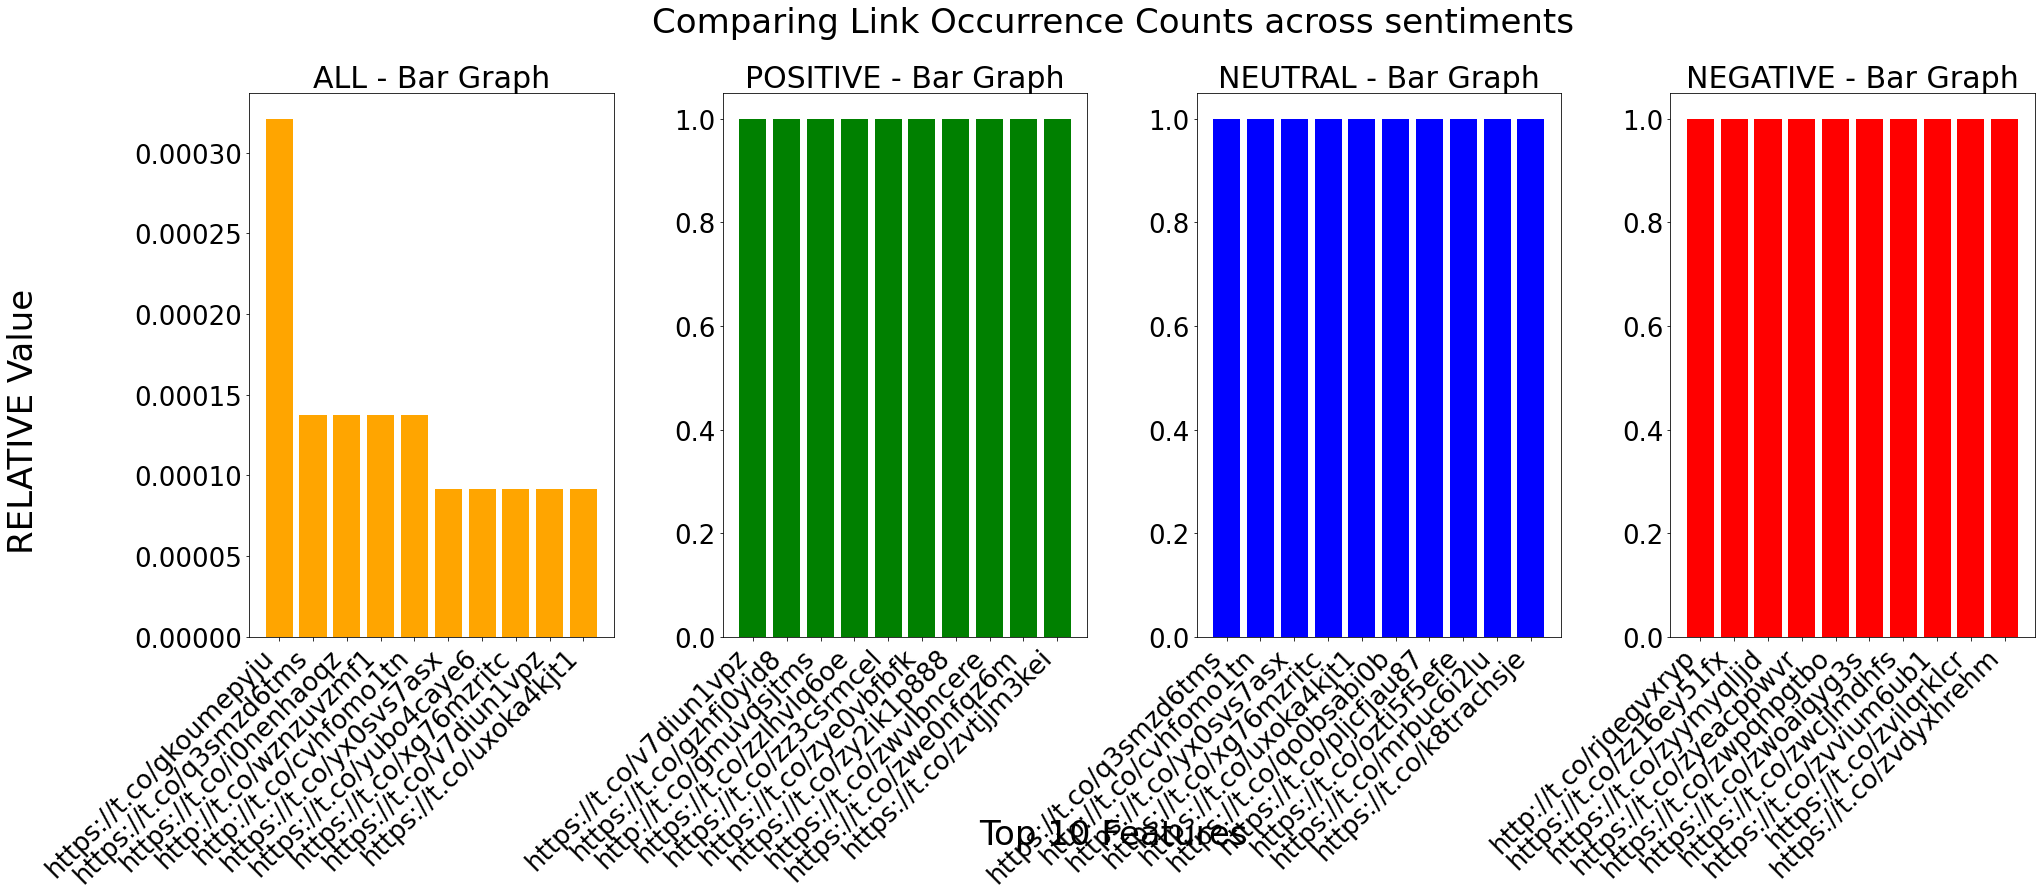

In [54]:
def tokenizer_links(tweet): return RE_LINKS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_LINKS_COUNT = 'Link Occurrence Counts'
cv_link = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_links)
X_train_features[FEATURE_LINKS_COUNT] = cv_link.fit_transform(train_df['text'])
X_test_features[FEATURE_LINKS_COUNT] = cv_link.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_LINKS_COUNT], y, cv_link.get_feature_names_out(), FEATURE_LINKS_COUNT)

if USE_TFIDF:
    # test the regular word split tokenization on the tf-idf
    FEATURE_LINKS_TFIDF = 'TF-IDF of Links'
    tfidf_link = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_links)
    X_train_features[FEATURE_LINKS_TFIDF] = tfidf_link.fit_transform(train_df['text'])
    X_test_features[FEATURE_LINKS_TFIDF] = tfidf_link.transform(test_df['text'])
    compare_bars(X_train_features[FEATURE_LINKS_TFIDF], y, tfidf_link.get_feature_names_out(), FEATURE_LINKS_TFIDF)

### Hashtags

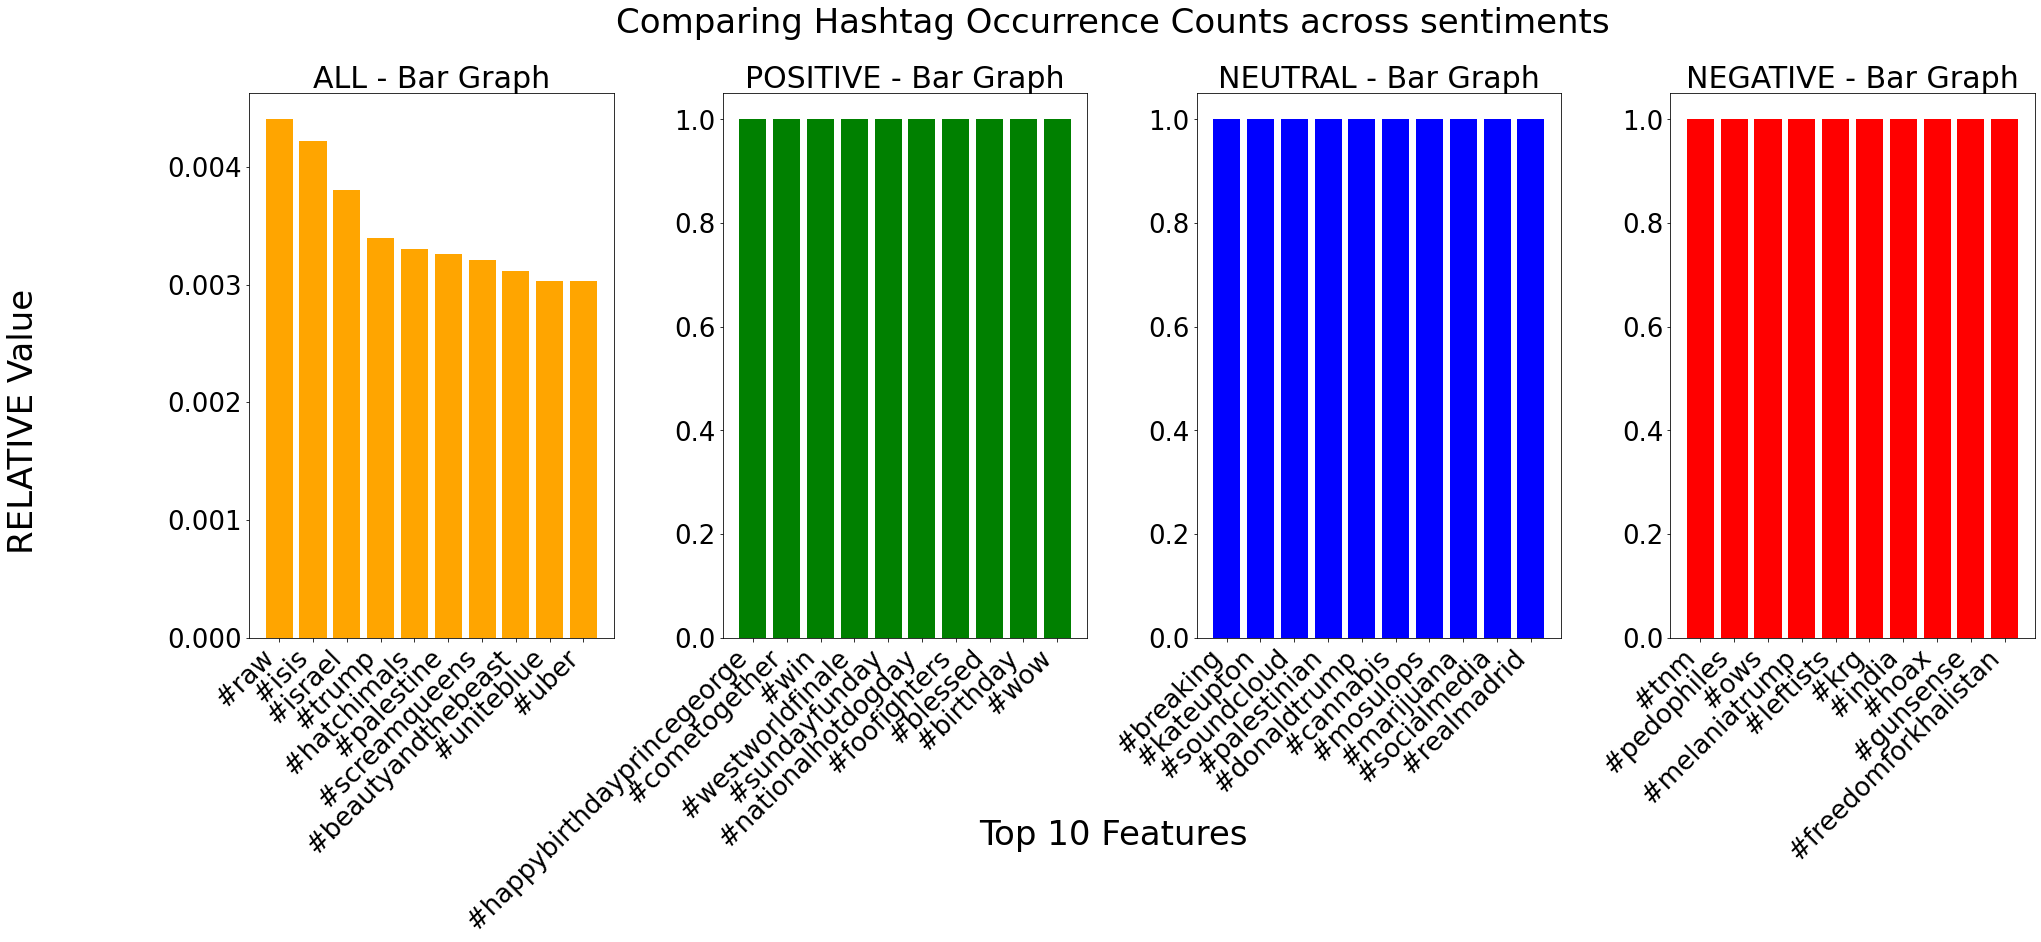

In [55]:
def tokenizer_hashtags(tweet): return RE_HASHTAGS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_HASHTAGS_COUNT = 'Hashtag Occurrence Counts'
cv_ht = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_hashtags)
X_train_features[FEATURE_HASHTAGS_COUNT] = cv_ht.fit_transform(train_df['text'])
X_test_features[FEATURE_HASHTAGS_COUNT] = cv_ht.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_HASHTAGS_COUNT], y, cv_ht.get_feature_names_out(), FEATURE_HASHTAGS_COUNT)

if USE_TFIDF:
    # test the regular word split tokenization on the tf-idf
    FEATURE_HASHTAGS_TFIDF = 'TF-IDF of Hashtags'
    tfidf_ht = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_hashtags)
    X_train_features[FEATURE_HASHTAGS_TFIDF] = tfidf_ht.fit_transform(train_df['text'])
    X_test_features[FEATURE_HASHTAGS_TFIDF] = tfidf_ht.transform(test_df['text'])
    compare_bars(X_train_features[FEATURE_HASHTAGS_TFIDF], y, tfidf_ht.get_feature_names_out(), FEATURE_HASHTAGS_TFIDF)

### Mentions

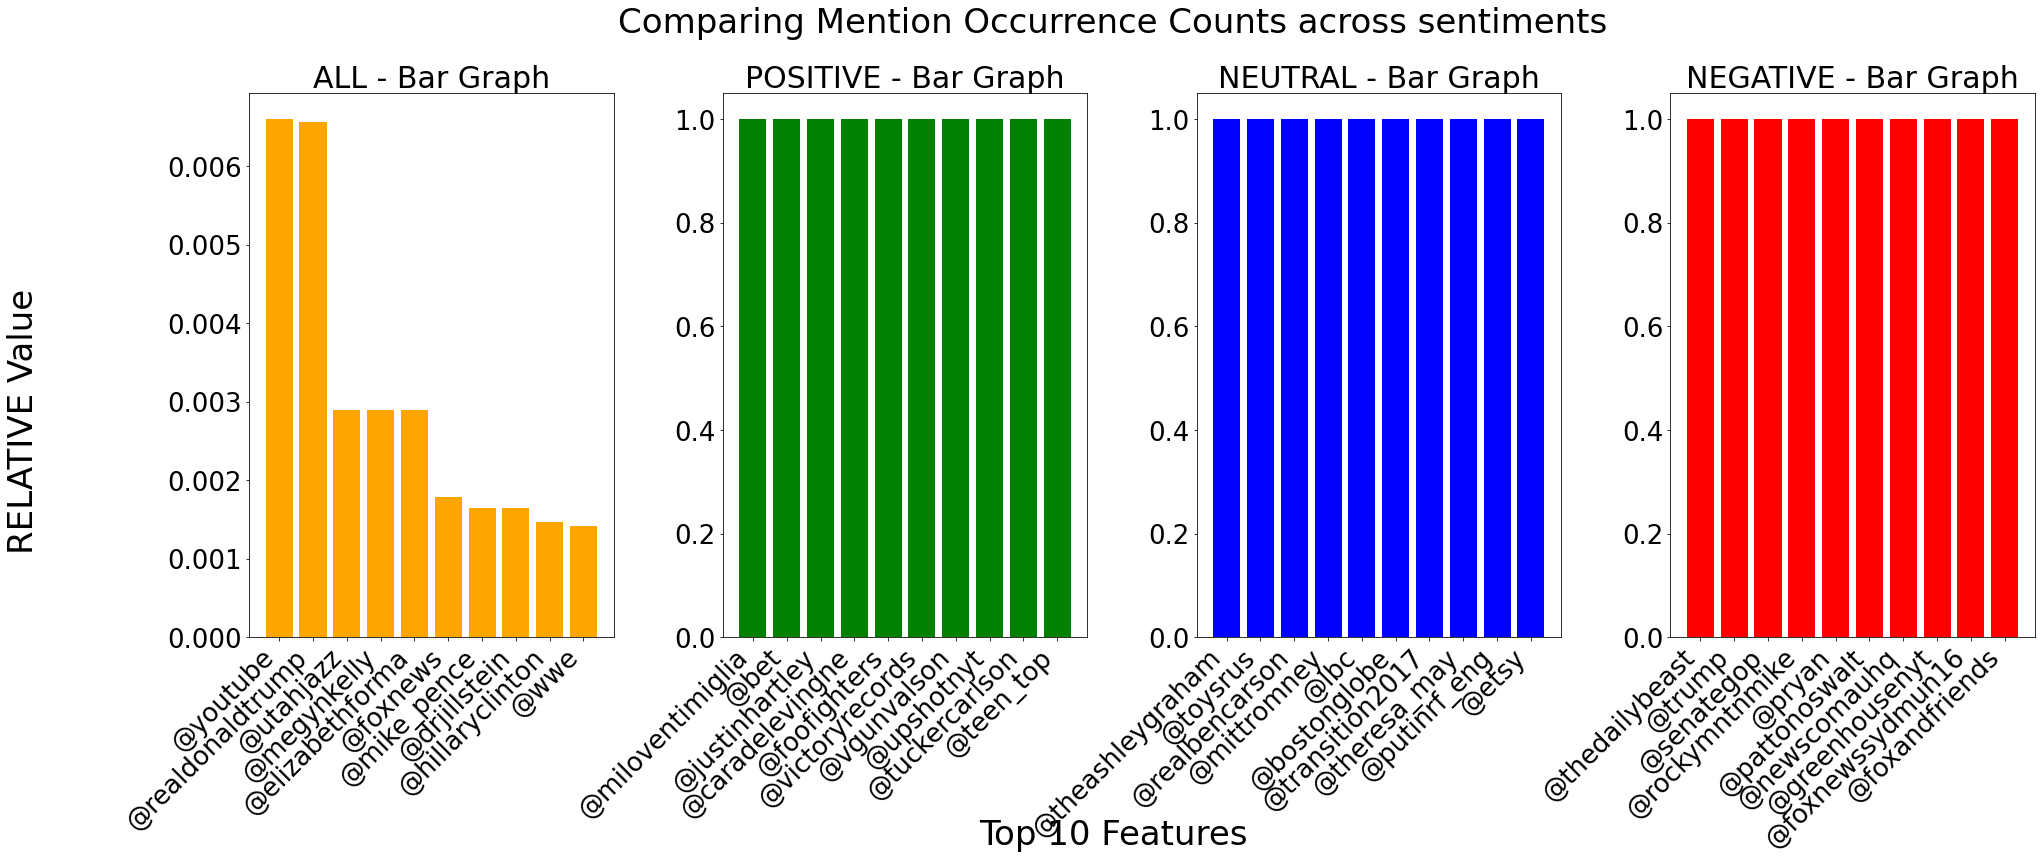

In [56]:
def tokenizer_mentions(tweet): return RE_MENTIONS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_MENTIONS_COUNT = 'Mention Occurrence Counts'
cv_at = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_mentions)
X_train_features[FEATURE_MENTIONS_COUNT] = cv_at.fit_transform(train_df['text'])
X_test_features[FEATURE_MENTIONS_COUNT] = cv_at.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_MENTIONS_COUNT], y, cv_at.get_feature_names_out(), FEATURE_MENTIONS_COUNT)

if USE_TFIDF:
    # test the regular word split tokenization on the tf-idf
    FEATURE_MENTIONS_TFIDF = 'TF-IDF of Mentions'
    tfidf_at = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_mentions)
    X_train_features[FEATURE_MENTIONS_TFIDF] = tfidf_at.fit_transform(train_df['text'])
    X_test_features[FEATURE_MENTIONS_TFIDF] = tfidf_at.transform(test_df['text'])
    compare_bars(X_train_features[FEATURE_MENTIONS_TFIDF], y, tfidf_at.get_feature_names_out(), FEATURE_MENTIONS_TFIDF)

### Emoticons


In [57]:
# define the sets of symbols to construct the emoticons
CH_EMOTE_EYES = r';:8='  # eye symbols
CH_EMOTE_MIDDLE = r'\',\-\"\*'  # middle symbols
CH_EMOTE_MOUTHS_HAP = r')3\]'  # happy/cutesy mouths
CH_EMOTE_MOUTHS_HAP_BACK = r'(\[' # if the emote is reversed these are happy mouths
CH_EMOTE_MOUTHS_SAD = r'\\/(\['  # sad/unhappy mouths
CH_EMOTE_MOUTHS_SAD_BACK = r'p)\]'  # if the emote is reversed these are sad mouths
CH_EMOTE_MOUTHS_SUR = r'vo'  # surprised mouths
CH_EMOTE_MOUTHS_NEU = r'pl\|'  # neutral mouths
CH_EMOTE_MOUTHS = CH_EMOTE_MOUTHS_HAP + CH_EMOTE_MOUTHS_SAD + \
    CH_EMOTE_MOUTHS_SUR + CH_EMOTE_MOUTHS_NEU
# Only allow one type of mouth to be found at a time (`:\3` is not allowed)
CH_EMOTES = r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_HAP + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_SAD + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_SUR + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_NEU + r']+(?=[\W])|'
# add the backwards results
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_HAP_BACK + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_SAD_BACK + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_NEU + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])'

RE_EMOTES = re.compile(CH_EMOTES)

# Simplifies emoticons to remove middle symbols and simplify eyes
# (since it's really the mouth that gives emotion away)
def simplify_emoticon(emote):
    DEFAULT_EYES = ":"
    DEFAULT_NOSE = ""
    DEFAULT_MOUTH_HAP = ")"
    DEFAULT_MOUTH_SAD = "("
    DEFAULT_MOUTH_SUR = "o"
    DEFAULT_MOUTH_NEU = "|"

    # reverse it if needed
    if emote[0] in CH_EMOTE_MOUTHS_HAP_BACK:
        emote = emote[::-1]
        emote = re.sub(r"[" + CH_EMOTE_MOUTHS_HAP_BACK + r"]+",
                        DEFAULT_MOUTH_HAP, emote)
    elif emote[0] in CH_EMOTE_MOUTHS_SAD_BACK:
        emote = emote[::-1]
        emote = re.sub(r"[" + CH_EMOTE_MOUTHS_SAD_BACK + r"]+",
                        DEFAULT_MOUTH_SAD, emote)
    elif emote[0] in CH_EMOTE_MOUTHS_NEU:
        emote = emote[::-1]

    # shrink the emote to one of the simple :) :( :| :o emotes.
    e_simple = ""
    for symbol in emote:
        if symbol in CH_EMOTE_EYES:
            symbol = DEFAULT_EYES
        elif symbol in CH_EMOTE_MIDDLE:
            symbol = DEFAULT_NOSE
        elif symbol in CH_EMOTE_MOUTHS_HAP:
            symbol = DEFAULT_MOUTH_HAP
        elif symbol in CH_EMOTE_MOUTHS_SAD:
            symbol = DEFAULT_MOUTH_SAD
        elif symbol in CH_EMOTE_MOUTHS_SUR:
            symbol = DEFAULT_MOUTH_SUR
        elif symbol in CH_EMOTE_MOUTHS_NEU:
            symbol = DEFAULT_MOUTH_NEU
        if len(e_simple) > 0:
            if symbol == e_simple[-1]:
                continue
            if symbol in CH_EMOTE_MOUTHS and e_simple[-1] in CH_EMOTE_MOUTHS:
                continue
        e_simple += symbol

    return e_simple

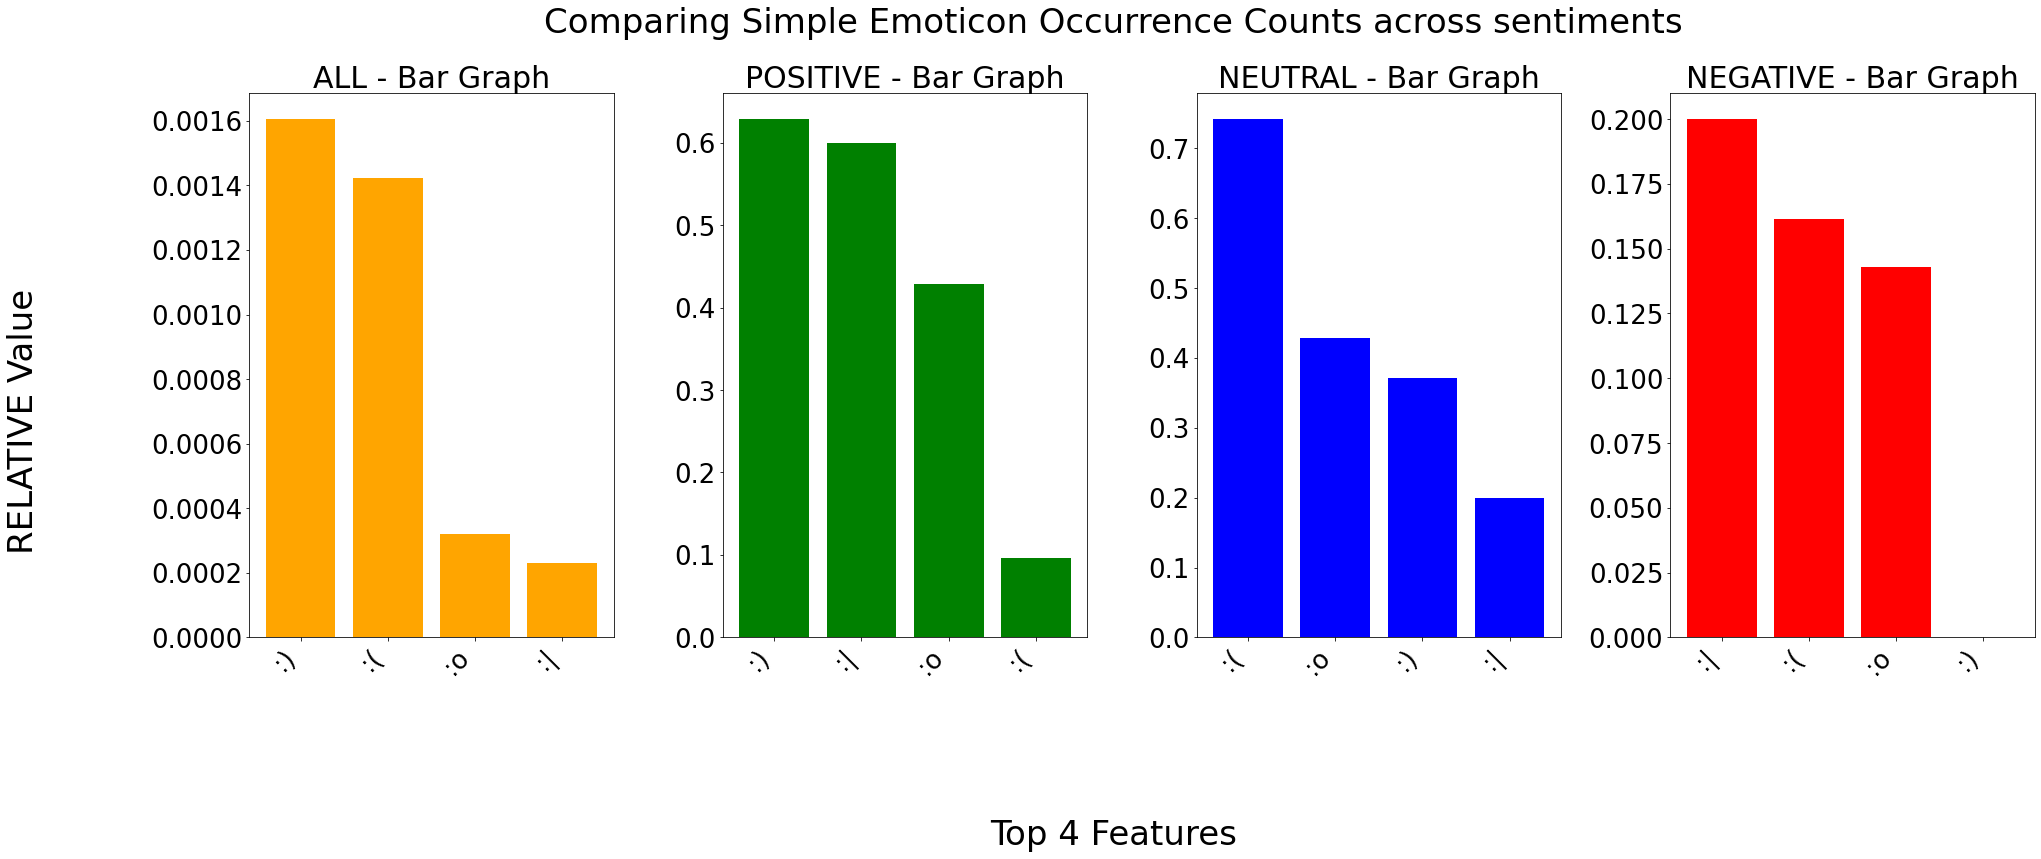

In [58]:
# tokenize into emotes
def tokenizer_emotes(tweet, remove_repeated=True, simplify=False): 
    if remove_repeated:
        tweet = re.sub(r'(.)\1+', r'\1', tweet)
    emotes = RE_EMOTES.findall(tweet)
    # prune numbers/decimals emotes
    emotes = [e for e in emotes if not (e.isalnum() or e.isdecimal() or e.isdigit())]
    if simplify:
        return [simplify_emoticon(e) for e in emotes]
    return emotes

# # test the regular word split tokenization on the count/bag-of-words
# FEATURE_EMOTICONS_COUNT = 'Emoticon Occurrence Counts'
# cv_emo = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_emotes)
# X_train_features[FEATURE_EMOTICONS_COUNT] = cv_emo.fit_transform(train_df['text'])
# X_test_features[FEATURE_EMOTICONS_COUNT] = cv_emo.transform(test_df['text'])
# compare_bars(X_train_features[FEATURE_EMOTICONS_COUNT], y, cv_emo.get_feature_names_out(), FEATURE_EMOTICONS_COUNT)

# # test the regular word split tokenization on the tf-idf
# FEATURE_EMOTICONS_TFIDF = 'TF-IDF of Emoticons'
# tfidf_emo = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_emotes)
# X_train_features[FEATURE_EMOTICONS_TFIDF] = tfidf_emo.fit_transform(train_df['text'])
# X_test_features[FEATURE_EMOTICONS_TFIDF] = tfidf_emo.transform(test_df['text'])
# compare_bars(X_train_features[FEATURE_EMOTICONS_TFIDF], y, tfidf_emo.get_feature_names_out(), FEATURE_EMOTICONS_TFIDF)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_EMOTICONS_SIMPLE_COUNT = 'Simple Emoticon Occurrence Counts'
cv_simemo = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=lambda t: tokenizer_emotes(t, simplify=True))
X_train_features[FEATURE_EMOTICONS_SIMPLE_COUNT] = cv_simemo.fit_transform(train_df['text'])
X_test_features[FEATURE_EMOTICONS_SIMPLE_COUNT] = cv_simemo.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_EMOTICONS_SIMPLE_COUNT], y, cv_simemo.get_feature_names_out(), FEATURE_EMOTICONS_SIMPLE_COUNT)

if USE_TFIDF:
    # test the regular word split tokenization on the tf-idf
    FEATURE_EMOTICONS_SIMPLE_TFIDF = 'TF-IDF of Simple Emoticons'
    tfidf_simemo = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_emotes(t, simplify=True))
    X_train_features[FEATURE_EMOTICONS_SIMPLE_TFIDF] = tfidf_simemo.fit_transform(train_df['text'])
    X_test_features[FEATURE_EMOTICONS_SIMPLE_TFIDF] = tfidf_simemo.transform(test_df['text'])
    compare_bars(X_train_features[FEATURE_EMOTICONS_SIMPLE_TFIDF], y, tfidf_simemo.get_feature_names_out(), FEATURE_EMOTICONS_SIMPLE_TFIDF)


### Phonetics

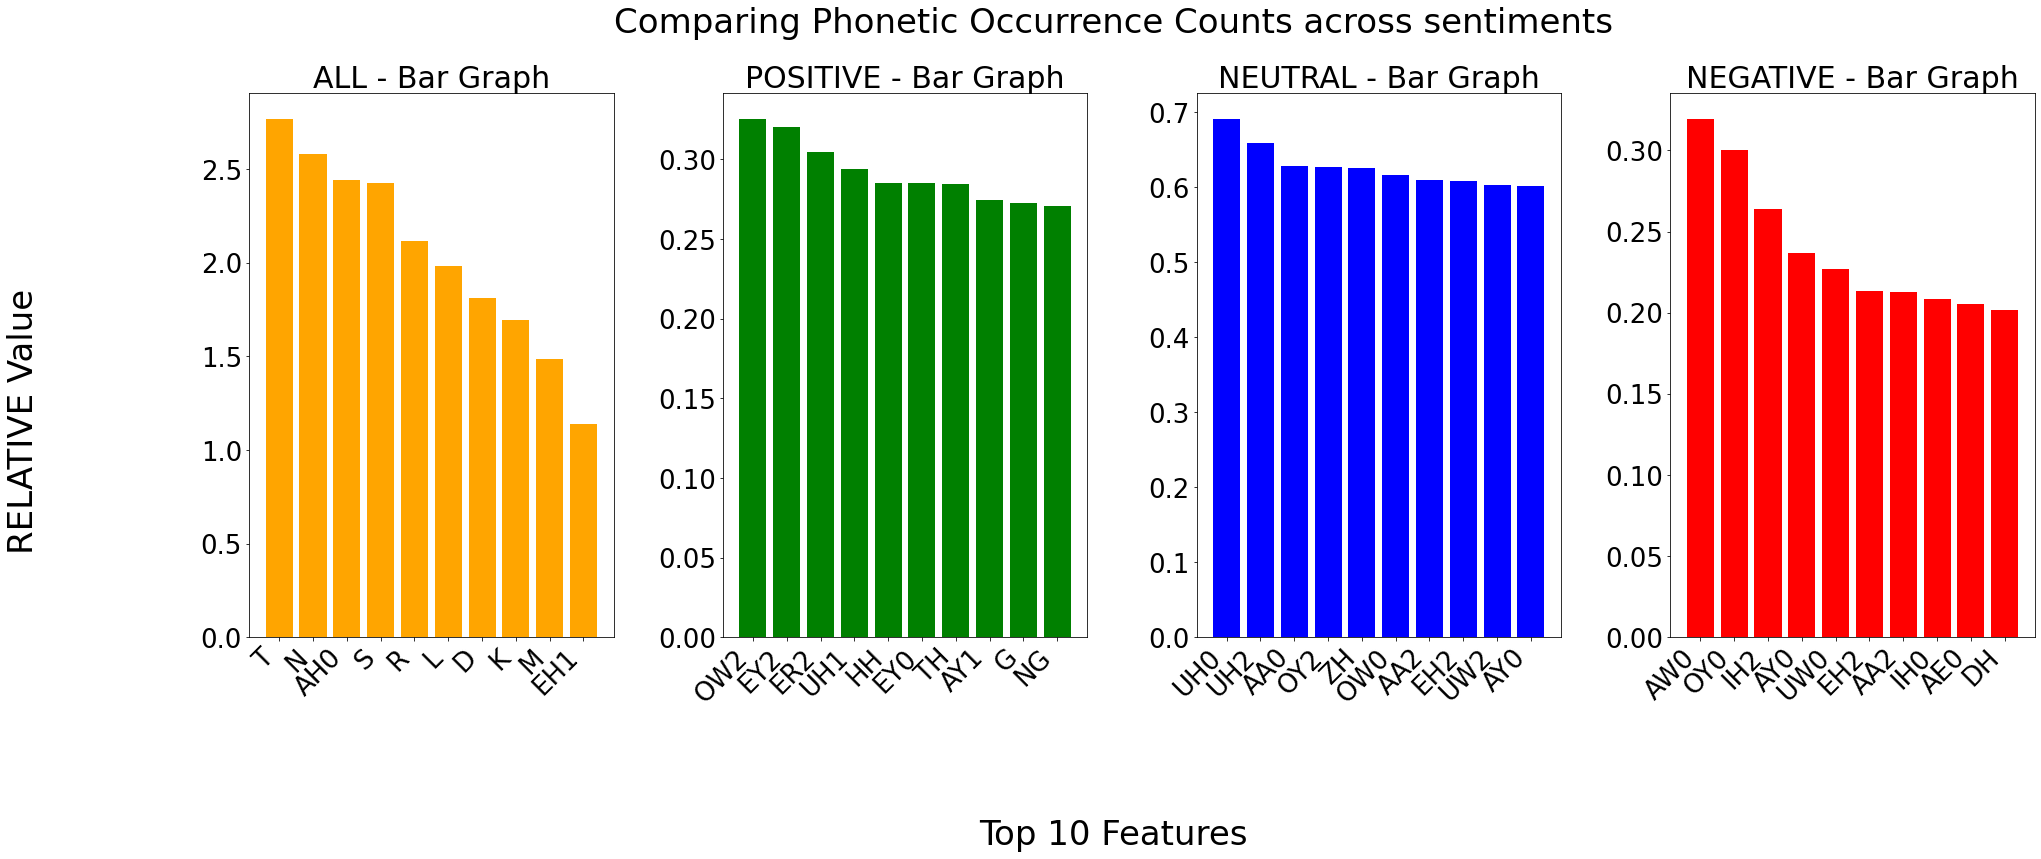

In [59]:
def tokenizer_phonetic(tweet): 
    wlist = tweet.split(' ')
    all_phones = []
    for w in wlist:
        # get the phones breakdown of the words
        if w not in NLTK_CMU: continue
        phones = NLTK_CMU[w]
        if len(phones) > 0:
            all_phones += phones[0]
    return all_phones

# test the regular word split tokenization on the count/bag-of-words
FEATURE_PHONETICS_COUNT = 'Phonetic Occurrence Counts'
cv_ph = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_phonetic)
X_train_features[FEATURE_PHONETICS_COUNT] = cv_ph.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_PHONETICS_COUNT] = cv_ph.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_PHONETICS_COUNT], y, cv_ph.get_feature_names_out(), FEATURE_PHONETICS_COUNT)

if USE_TFIDF:
    # test the regular word split tokenization on the tf-idf
    FEATURE_PHONETICS_TFIDF = 'TF-IDF of Phonetics'
    tfidf_ph = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_phonetic)
    X_train_features[FEATURE_PHONETICS_TFIDF] = tfidf_ph.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_PHONETICS_TFIDF] = tfidf_ph.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_PHONETICS_TFIDF], y, tfidf_ph.get_feature_names_out(), FEATURE_PHONETICS_TFIDF)

### Poetic Phonetics

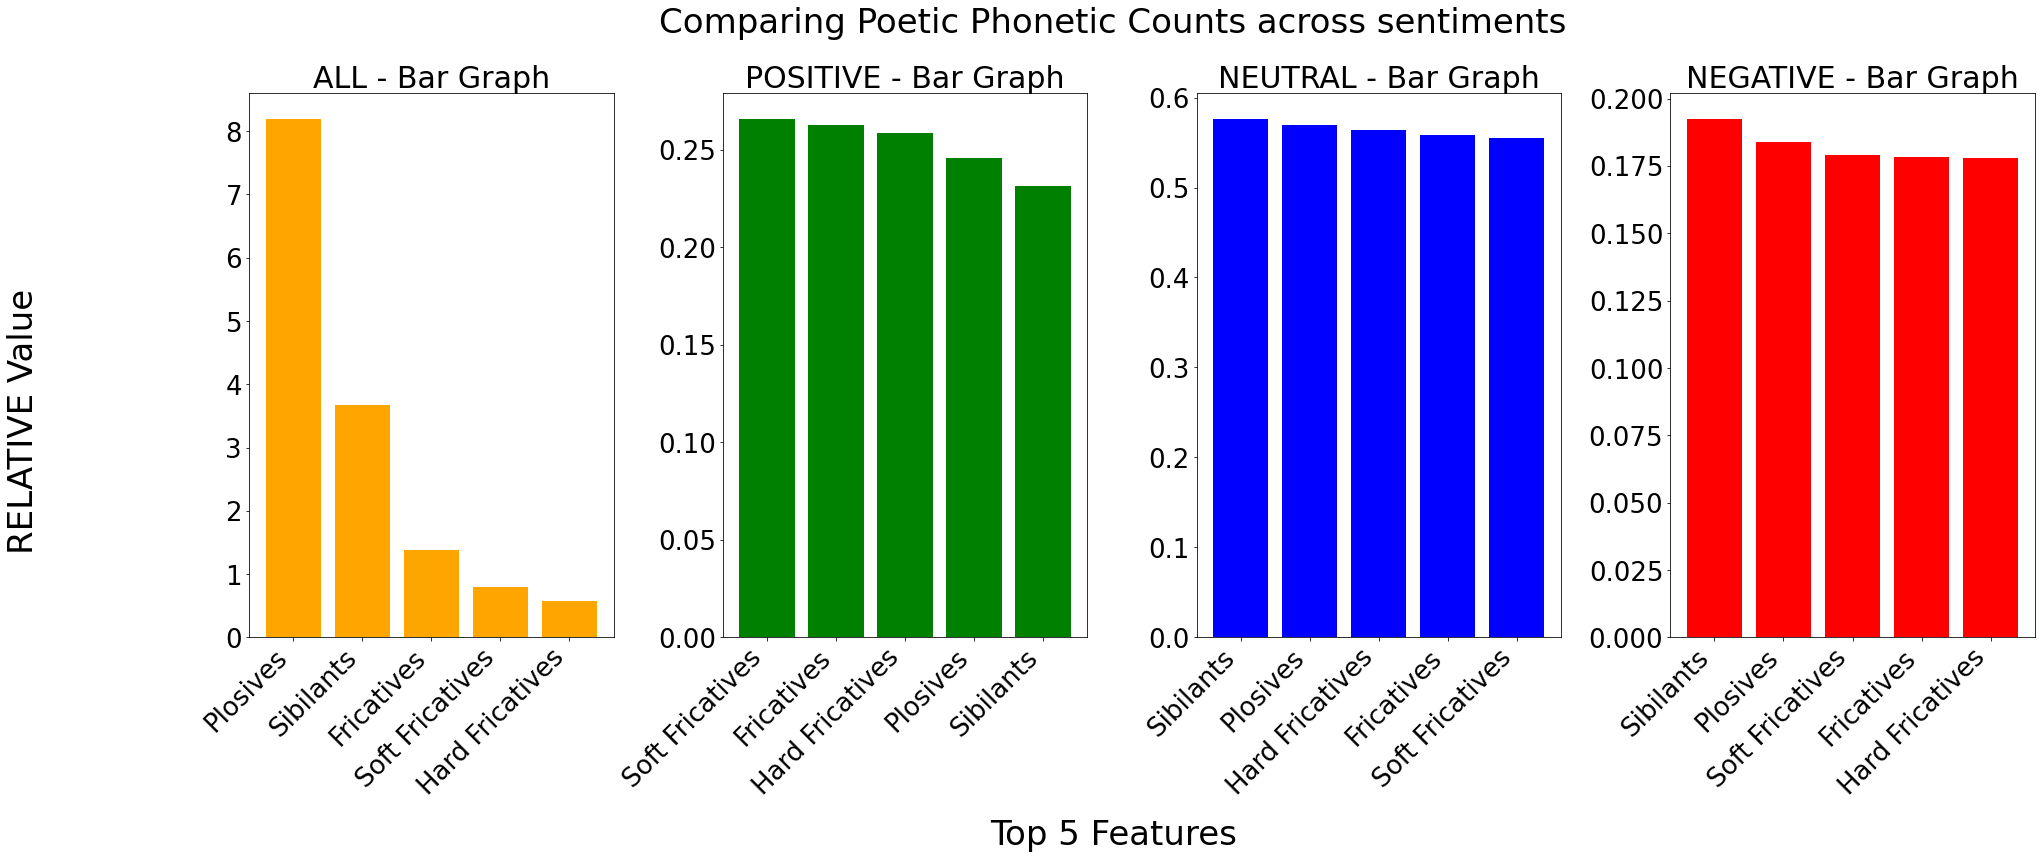

In [60]:
FEATURE_POETICS = 'Poetic Phonetic Counts'
plosive_set = ['B', 'P', 'D', 'T', 'G', 'K',
                'BCL', 'PCL', 'DCL', 'TCL', 'GCL', 'KCL', 'DX']
ch_plosive = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(plosive_set) + r"(?=[ $])"
RE_PLOSIVES = re.compile(ch_plosive)

fricative_hard_set = ['DH', 'V']
ch_fricative_hard = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_hard_set) + r"(?=[ $])"
RE_FRICATIVES_HARD = re.compile(ch_fricative_hard)

fricative_soft_set = ['TH', 'F']
ch_fricative_soft = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_soft_set) + r"(?=[ $])"
RE_FRICATIVES_SOFT = re.compile(ch_fricative_soft)

fricative_set = fricative_hard_set + fricative_soft_set
ch_fricative = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_set) + r"(?=[ $])"
RE_FRICATIVES = re.compile(ch_fricative)

sibilant_set = ['Z', 'S', 'CH', 'SH', 'ZH']
ch_sibilant = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(sibilant_set) + r"(?=[ $])"
RE_SIBILANTS = re.compile(ch_sibilant)

def dictorizer_poetic_counts(tweets): 
    dict_list = []

    for t in tweets:
        wlist = t.split(' ')
        all_phones = []
        for w in wlist:
            # get the phones breakdown of the words
            if w not in NLTK_CMU: continue
            phones = NLTK_CMU[w]
            if len(phones) > 0:
                all_phones += phones[0]
        str_phones = ' '.join(all_phones)
        t_dict = {
            'Plosives': len(RE_PLOSIVES.findall(str_phones)),
            'Sibilants': len(RE_SIBILANTS.findall(str_phones)),
            'Fricatives': len(RE_FRICATIVES.findall(str_phones)),
            'Hard Fricatives': len(RE_FRICATIVES_HARD.findall(str_phones)),
            'Soft Fricatives': len(RE_FRICATIVES_SOFT.findall(str_phones)),
        }
        dict_list.append(t_dict)
    return dict_list


# test the regular word split tokenization on the count/bag-of-words
dv_poe = DictVectorizer()
X_train_features[FEATURE_POETICS] = dv_poe.fit_transform(dictorizer_poetic_counts(train_df['text-clean']))
X_test_features[FEATURE_POETICS] = dv_poe.transform(dictorizer_poetic_counts(test_df['text-clean']))
compare_bars(X_train_features[FEATURE_POETICS], y, dv_poe.get_feature_names_out(), FEATURE_POETICS)

### General Metrics

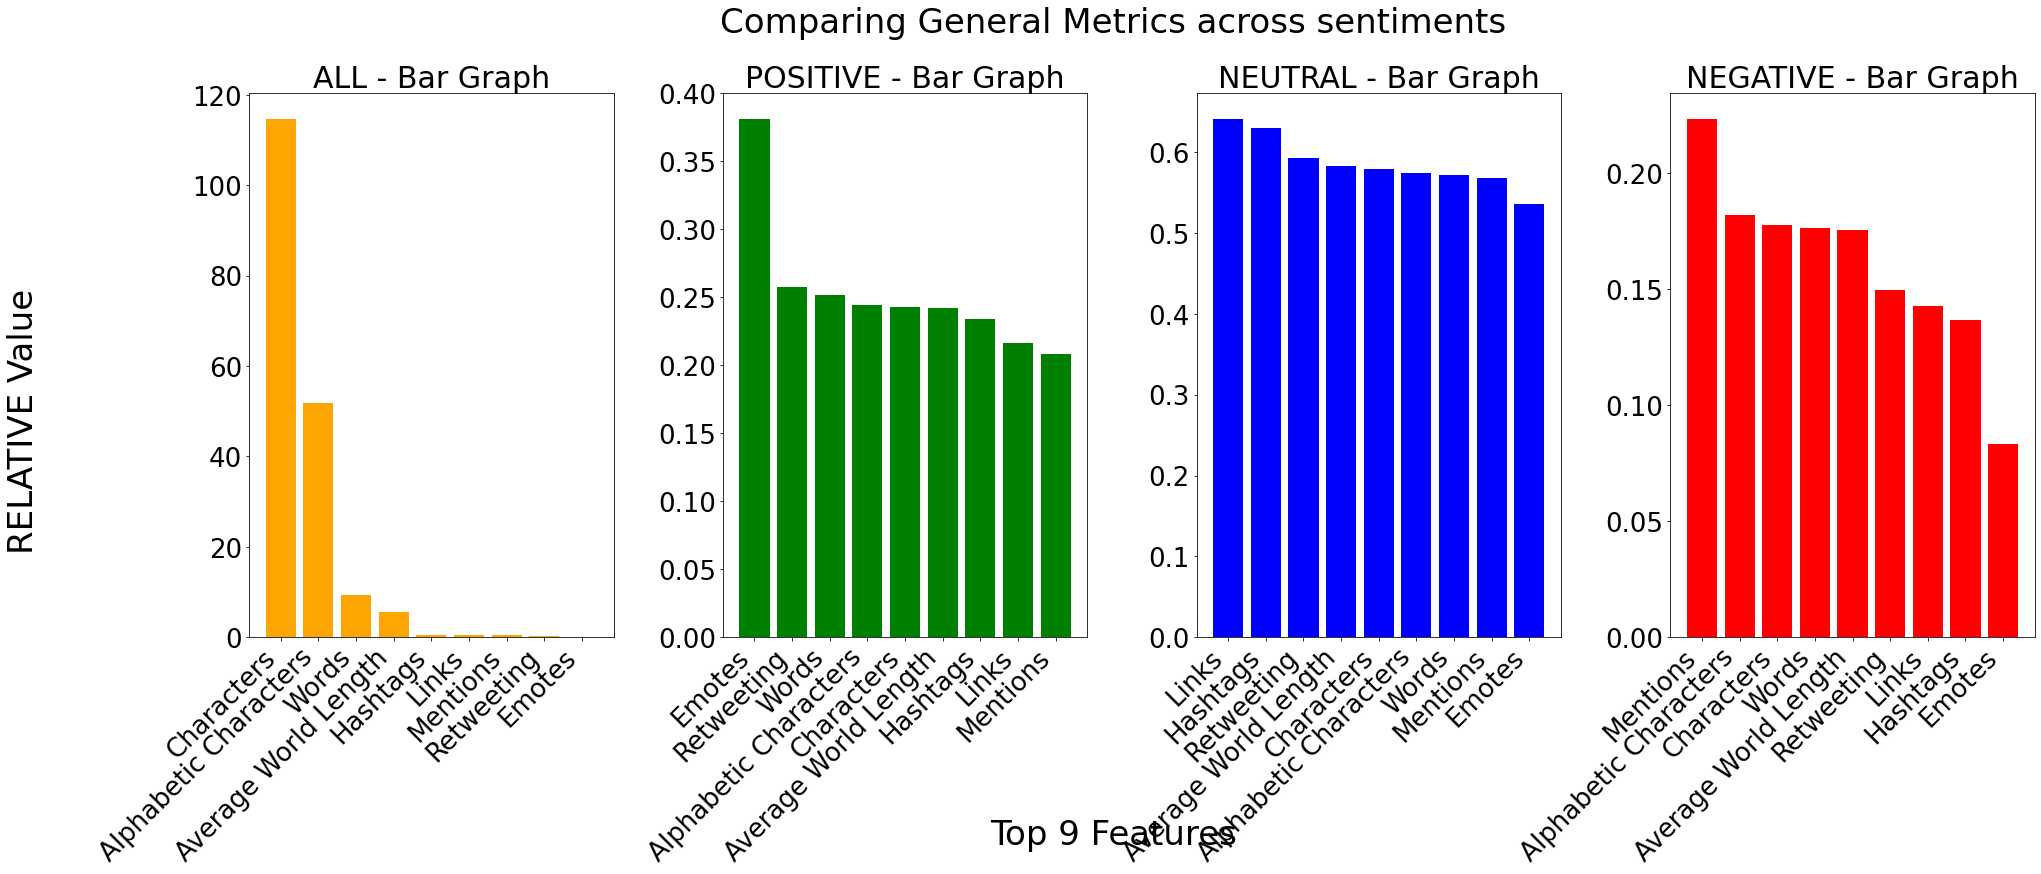

In [61]:
FEATURE_METRICS = 'General Metrics'
def dictorizer_metrics(tweets: list[str], tweets_cleaned: list[str]): 
    dict_list = []
    for t, t_clean in zip(tweets, tweets_cleaned):
        wlist = t_clean.split(' ')
        total_wlen = 0
        for w in wlist:
            total_wlen += len(w)

        t_dict = {
            'Links': len(RE_LINKS.findall(t)),
            'Hashtags': len(RE_HASHTAGS.findall(t)),
            'Mentions': len(RE_MENTIONS.findall(t)),
            'Words': len(wlist),
            'Average World Length': total_wlen / len(wlist),
            'Emotes': len(RE_EMOTES.findall(t)),
            'Retweeting': ('"' in t),
            'Characters': len(t),
            'Alphabetic Characters': len(re.sub(r' +', '', t_clean))
        }
        dict_list.append(t_dict)
    return dict_list


# test the regular word split tokenization on the count/bag-of-words
dv_metrics = DictVectorizer()
X_train_features[FEATURE_METRICS] = dv_metrics.fit_transform(dictorizer_metrics(train_df['text'], train_df['text-clean']))
X_test_features[FEATURE_METRICS] = dv_metrics.transform(dictorizer_metrics(test_df['text'], test_df['text-clean']))
compare_bars(X_train_features[FEATURE_METRICS], y, dv_metrics.get_feature_names_out(), FEATURE_METRICS)

## 5. Model Selection

Selecting, training, and evaluating possible models.

### Helper Functions

In [62]:
# Combine the chosen tokens into one matrix
# Generate the final train and test sets
def combine_X_matrices(train_dict: dict, test_dict: dict, feature_types: list[str]):
    X_Train = hstack([train_dict[ft] for ft in feature_types])
    X_Test = hstack([test_dict[ft] for ft in feature_types])
    
    return (X_Train, X_Test)

### Generating Features

In [63]:
# Choose the features for the train and test sets
CHOSEN_FEATURES = [
    FEATURE_HASHTAGS_COUNT,
    FEATURE_MENTIONS_COUNT,
    FEATURE_LINKS_COUNT,
    FEATURE_POS_TAGS_COUNT, 
    FEATURE_WORDS_COUNT, 
    FEATURE_WORD_2GRAMS_COUNT,
    FEATURE_WORD_LENGTHS_COUNT,
    FEATURE_PHONETICS_COUNT,
    FEATURE_ALPHABETICS_COUNT,
    FEATURE_PUNCTUATION_COUNT,
    FEATURE_EMOTICONS_SIMPLE_COUNT,
    FEATURE_METRICS]
X_train, X_test = combine_X_matrices(X_train_features, X_test_features, CHOSEN_FEATURES)

print(f'\tModified Training Set Shape: {X_train.shape}')
print(f'\tModified Testing Set Shape: {X_test.shape}')

	Modified Training Set Shape: (21802, 40599)
	Modified Testing Set Shape: (6099, 40599)


### Evaluation

#### Distribution generation

In [64]:
# function to display the distribution of a train and test split
def show_save_sentiment_distribution(d_y_train, d_y_test, y, split_type):
    labels  = []
    weights = []
    colours = []
    for s in sorted(set(y), reverse=True):
        labels.append(f'Training {s}')
        weights.append(len(d_y_train[d_y_train == s]))
        colours.append(SENTIMENT_COLOURS[s])

        labels.append(f'Testing {s}')
        weights.append(len(d_y_test[d_y_test == s]))
        colours.append('dark' + SENTIMENT_COLOURS[s])

    plt.figure(figsize= (16, 9))
    plt.bar(labels, weights, color=colours)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Distribution of the Sentiments in a {split_type.upper()} Split')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.savefig(f'../report/img/train-test-sentiments-{split_type}', bbox_inches='tight')


SPLIT_UNIFORM = 'Uniform'
SPLIT_RANDOM = 'Random'

### generating splits (and comparing the distributions of the true sentiments)
# generate a split similar to the overall sentiment distribution
def generate_datadist_sentiments(X:csr_matrix, y, train_uniform_len, test_uniform_len):
    return train_test_split(X, y, train_size=train_uniform_len, test_size=test_uniform_len, random_state=101)

# generate a uniform split
def generate_uniform_sentiments(X:csr_matrix, y, test_size:float = 0.2):

    # number of elements per sentiment
    n = int(len(y) / 3)

    # ensure that n is not greater than any sentiments actual count
    for s in set(y):
        n = min(len(y[y == s]), n)

    # create the train and test sizes
    train_n = int((1 - test_size) * n)
    test_n = int((test_size) * n)

    # extract the different sentiment values
    _X_train = None
    _X_test = None
    _y_train = []
    _y_test = []

    for s in set(y):
        if _X_train == None:
            _X_train    = X[y == s][:train_n]
            _X_test     = X[y == s][-test_n:]
            _y_train    = y[y == s][:train_n]
            _y_test     = y[y == s][-test_n:]
        else:
            _X_train    = vstack([_X_train, X[y == s][:train_n]])
            _X_test     = vstack([_X_test, X[y == s][-test_n:]])
            _y_train    = pd.concat([_y_train, y[y == s][:train_n]])
            _y_test     = pd.concat([_y_test, y[y == s][-test_n:]])

    return _X_train, _X_test, _y_train, _y_test

#### Testing different train/test splits

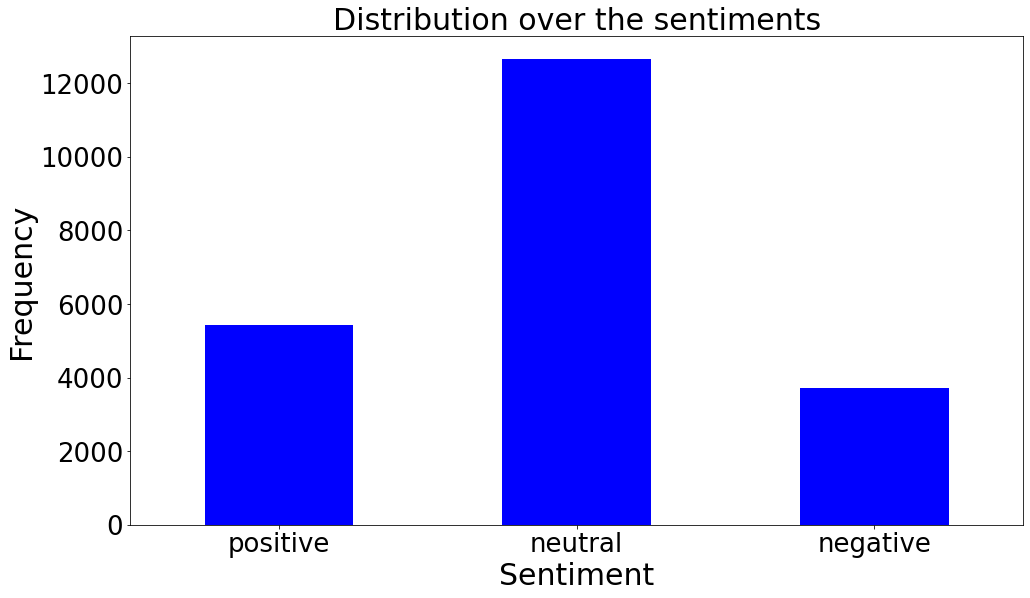

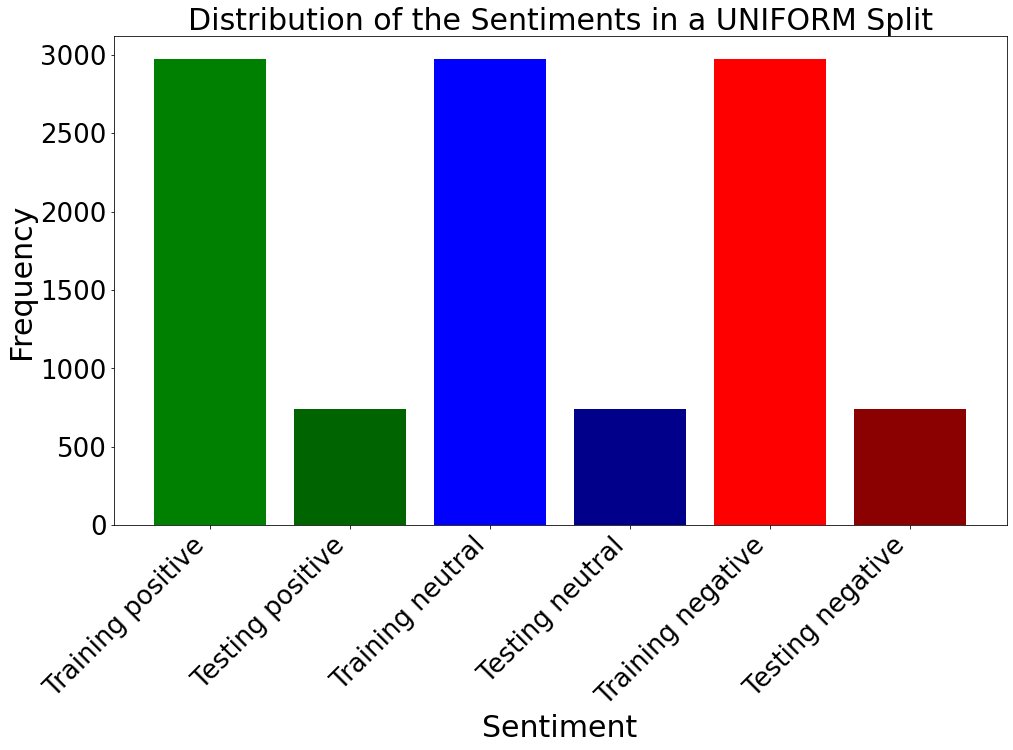

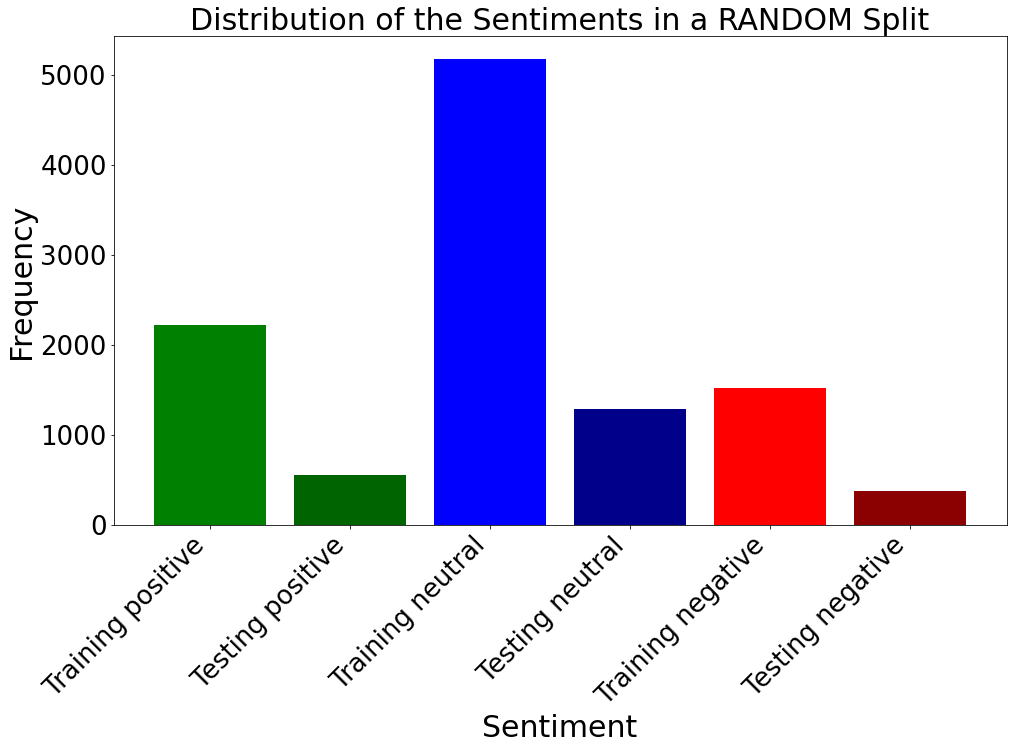

In [65]:
# as a reminder: Distribution of the data between the sentiments
train_df.groupby('sentiment').count().sort_values('sentiment', ascending=False).plot.bar(
    legend=False, figsize=(16, 9), color='blue', rot=0)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution over the sentiments')
plt.savefig('../report/img/sentiment-distribution', bbox_inches='tight')

uni_X_train, uni_X_test, uni_y_train, uni_y_test = generate_uniform_sentiments(X_train, y)
show_save_sentiment_distribution(uni_y_train, uni_y_test, y, 'Uniform')

rand_X_train, rand_X_test, rand_y_train, rand_y_test = generate_datadist_sentiments(X_train, y, 
    train_uniform_len=len(uni_y_train), test_uniform_len=len(uni_y_test))
show_save_sentiment_distribution(rand_y_train, rand_y_test, y, 'Random')

#### Evaluation Functions

In [66]:
# evaluate the cross validation score for the model
def evaluate_score(model, _X, _y, cv = 5):
    rand_scores = cross_val_score(model,  _X, _y, cv = cv, n_jobs=-1)

    # do the same on a uniform distribution split
    uni_X_train, uni_X_test, uni_y_train, uni_y_test = generate_uniform_sentiments(_X, _y)
    
    # recombine the train and test and use them for the cross_val_score
    uni_X = vstack([uni_X_train, uni_X_test])
    uni_y = pd.concat([uni_y_train, uni_y_test])

    uni_scores = cross_val_score(model, uni_X, uni_y, cv = cv, n_jobs=-1)

    scores = np.concatenate([rand_scores, uni_scores])

    return {
        'scores': scores,
        'average': np.ma.average(scores),
        'std': np.ma.std(scores),
        'rand-scores': rand_scores,
        'rand-average': np.ma.average(rand_scores),
        'rand-std': np.ma.std(rand_scores),
        'uni-scores': uni_scores,
        'uni-average': np.ma.average(uni_scores),
        'uni-std': np.ma.std(uni_scores),
    }

# generate the evaluation metrics and confusion matrix on a model on given data
def evaluate_metrics(model, _X_train, _X_test, _y_train, _y_test, split_type:str = '', model_name:str = '', display:bool = False):
    # fit the data and predict
    model.fit(_X_train, _y_train)
    _y_pred = model.predict(_X_test)

    # append a dictionary of the evaluation summaries
    output = {
        'data': (rand_X_train, rand_X_test, rand_y_train, rand_y_test, _y_pred),
        'evaluation-string': classification_report(_y_test, _y_pred, zero_division=0),
        'evaluation': classification_report(_y_test, _y_pred, output_dict=True, zero_division=0),
        'confusion-matrix': confusion_matrix(_y_test, _y_pred)
    }

    # display the stuff if needed
    if display:
        print(output['evaluation-string'])
        plt.figure(figsize=(32, 18))
        ConfusionMatrixDisplay.from_predictions(_y_test, _y_pred, xticks_rotation=45,
            labels = sorted(set(_y_test), reverse=True))
        plt.title(f'{model_name}\nConfusion Matrix on {split_type.upper()} Data')
        model_name = re.sub(r'\W+', '', model_name)
        split_type = re.sub(r'\W+', '', split_type)
        plt.savefig(f'../report/img/cf/{model_name}-{split_type}-confusion-matrix', bbox_inches='tight')

    return output

SPLIT_ALL = 'All'
SPLIT_RANDOM_ON_UNIFORM = 'Random Training\n and Uniform Testing'
SPLIT_UNIFORM_ON_RANDOM = 'Uniform Training\n and Random Testing'
# evaluate a model on the different data splits, then on overall data
def evaluate(model, _X, _y, model_name:str = '', display:bool=False):
    output = {}

    # get the uniform split
    if display: print(f'=== Over {SPLIT_UNIFORM} Data ===')
    uni_X_train, uni_X_test, uni_y_train, uni_y_test = generate_uniform_sentiments(_X, _y)
    output[SPLIT_UNIFORM] = evaluate_metrics(model, uni_X_train, uni_X_test, uni_y_train, uni_y_test, 
        split_type=SPLIT_UNIFORM, model_name=model_name, display=display)

    # get the random split
    if display: print(f'=== Over {SPLIT_RANDOM} Data ===')
    rand_X_train, rand_X_test, rand_y_train, rand_y_test = generate_datadist_sentiments(_X, _y, 
        train_uniform_len=len(uni_y_train), test_uniform_len=len(uni_y_test))
    output[SPLIT_RANDOM] = evaluate_metrics(model, rand_X_train, rand_X_test, rand_y_train, rand_y_test, 
        split_type=SPLIT_RANDOM, model_name=model_name, display=display)
    
    # train on random and test on uniform
    if display: print(f'=== Over {SPLIT_RANDOM_ON_UNIFORM} Data ===')
    output[SPLIT_RANDOM_ON_UNIFORM] = evaluate_metrics(model, rand_X_train, uni_X_test, rand_y_train, uni_y_test, 
        split_type=SPLIT_RANDOM_ON_UNIFORM, model_name=model_name, display=display)

    # train on uniform and test on random
    if display: print(f'=== Over {SPLIT_UNIFORM_ON_RANDOM} Data ===')
    output[SPLIT_UNIFORM_ON_RANDOM] = evaluate_metrics(model, uni_X_train, rand_X_test, uni_y_train, rand_y_test, 
        split_type=SPLIT_UNIFORM_ON_RANDOM, model_name=model_name, display=display)

    # now test evaluate over the whole set
    if display: print(f'=== Over {SPLIT_ALL} Data ===')
    output[SPLIT_ALL] = evaluate_metrics(model, _X, _X, _y, _y,
        split_type=SPLIT_ALL, model_name=model_name, display=display)
    
    return output

#### Start the model dictionairy

In [67]:
TYPE_CLASSIFIER = 'classifier'
TYPE_SCORES = 'cv-scores'
TYPE_EVALUATION = 'evaluation'
# will store the cv scores of all the models below, which can then be used to find the best models.
models = {}

### Baseline Model (0-R)

Most Frequent Class (0-R)
{'average': 0.45698407030062815,
 'rand-average': 0.5806348072679232,
 'rand-scores': array([0.58060078, 0.58060078, 0.58073394, 0.58073394, 0.58050459]),
 'rand-std': 8.823785859666561e-05,
 'scores': array([0.58060078, 0.58060078, 0.58073394, 0.58073394, 0.58050459,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333]),
 'std': 0.12365075270905147,
 'uni-average': 0.3333333333333333,
 'uni-scores': array([0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333]),
 'uni-std': 0.0}
=== Over Uniform Data ===
              precision    recall  f1-score   support

    negative       0.33      1.00      0.50       743
     neutral       0.00      0.00      0.00       743
    positive       0.00      0.00      0.00       743

    accuracy                           0.33      2229
   macro avg       0.11      0.33      0.17      2229
weighted avg       0.11      0.33      0.17      2229

=== Over Random Data ===
              precision    recall  f1-

<Figure size 2304x1296 with 0 Axes>

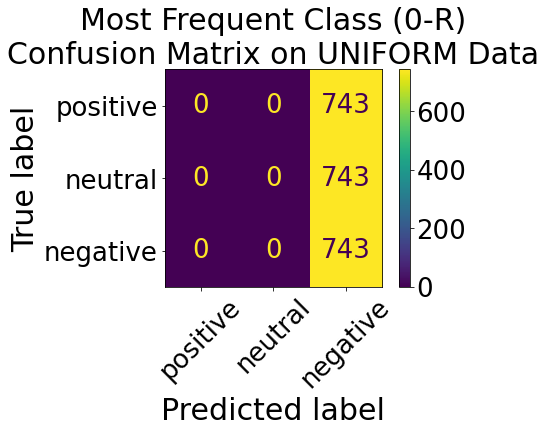

<Figure size 2304x1296 with 0 Axes>

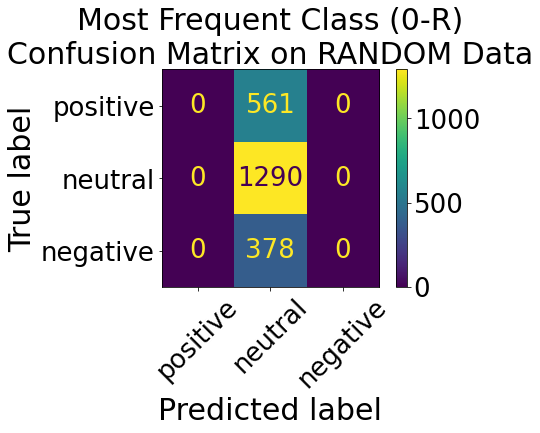

<Figure size 2304x1296 with 0 Axes>

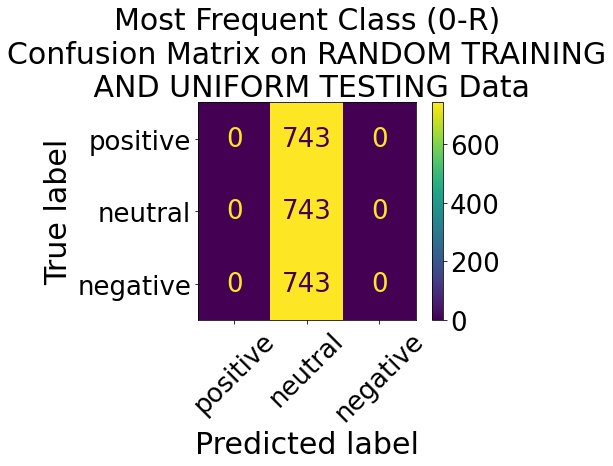

<Figure size 2304x1296 with 0 Axes>

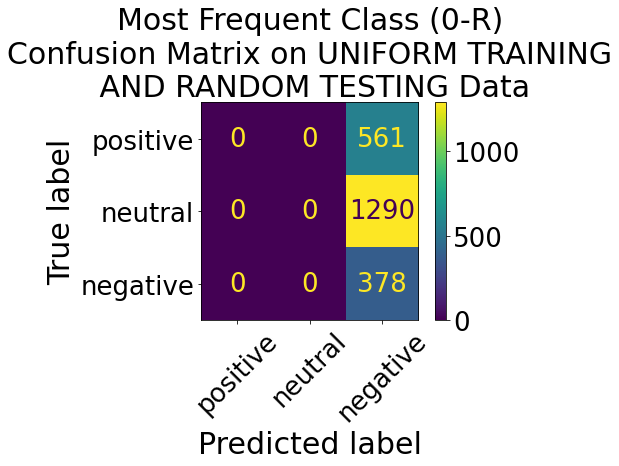

<Figure size 2304x1296 with 0 Axes>

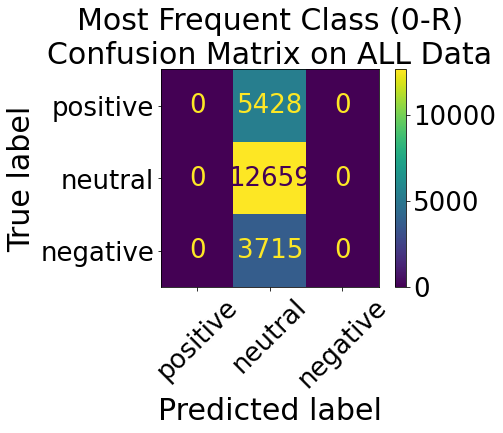

In [68]:
model_name = 'Most Frequent Class (0-R)'
print(model_name)
model_baseline = {}
# create the model
model_baseline[TYPE_CLASSIFIER] = DummyClassifier(strategy="most_frequent")

# Evaluate the model
model_baseline[TYPE_SCORES] = evaluate_score(model_baseline[TYPE_CLASSIFIER], X_train, y)
pprint(model_baseline[TYPE_SCORES])
model_baseline[TYPE_EVALUATION] = evaluate(model_baseline[TYPE_CLASSIFIER], X_train, y, model_name, display=True)


### Finding the Highest Accuracy Parameter/Classifier Configurations.

#### Iterate through possible parameter combinations and cross-validate

In [69]:
# warning takes up too much space so theyre suppressed, but noted
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=skl.exceptions.ConvergenceWarning)

# Generate the parameters for the pipeline
parameters = [
    {  # Multinomial/Bernoulli Naive Bayes
        TYPE_CLASSIFIER: [MultinomialNB(), BernoulliNB()],
        'alpha': [0, 1, 10],
        'fit_prior': [True, False],
    },
    {  # Logistic Regressions
        TYPE_CLASSIFIER: [LogisticRegression()],
        'max_iter': [100, 500],
        'fit_intercept': [True, False],
        'solver': ['sag', 'saga'],
    },
    {  # Decision Trees
        TYPE_CLASSIFIER: [DecisionTreeClassifier()],
        'max_depth': [1, 100, 500],
    },
    {  # K Nearest Neighbours
        TYPE_CLASSIFIER: [KNeighborsClassifier()],
        'n_neighbors': [1, 10, 100, 500],
        'weights': ['uniform', 'distance'],
    },
    {  # Support Vector Classifiers
        TYPE_CLASSIFIER: [SVC()],
        'kernel': ['poly'],
        'degree': [3],
        'C': [0.1, 1, 3],
        'decision_function_shape': ['ovo', 'ovr'],
    },
    {  # Linear Support Vector Classifiers
        TYPE_CLASSIFIER: [LinearSVC()],
        'C': [0.1, 1, 3],
    },
]

pGrid = ParameterGrid(parameters)
all_models = []
if False: # Uncomment this to find the best 3 classifiers by avg - std.
    for paramSet in pGrid:
        params = dict([(key, values) for (key, values) in paramSet.items() if key != TYPE_CLASSIFIER])
        paramSet[TYPE_CLASSIFIER].set_params(**params)
        print(f'\n#--- Cross-Validating {paramSet} ---#')
        paramSet[TYPE_SCORES] = evaluate_score(paramSet[TYPE_CLASSIFIER], X_train, y)
        pprint(paramSet[TYPE_SCORES])
        all_models.append({
            'params': params,
            TYPE_SCORES: paramSet[TYPE_SCORES],
            TYPE_CLASSIFIER: clone(paramSet[TYPE_CLASSIFIER])
        })

#### Choose the top 3 classifers by average score
Specifically, use `average - std` as the sorting key. This is the approximate lower bound for 80% of the highest accuracies

In [70]:
def sort_80_percent(model):
    return model[TYPE_SCORES]['average'] - model[TYPE_SCORES]['std']

top_models = sorted(all_models, reverse=True, key=sort_80_percent)[:3]

pprint(top_models)

[]


#### Now that I know the top 3 classifiers
Add them here and generate the evaluation metrics for each

Bernoulli Naive Bayes 
(alpha=1, fit_prior=True)
{'average': 0.6335351589153894,
 'rand-average': 0.6414085861125194,
 'rand-scores': array([0.64870443, 0.64411832, 0.65573394, 0.62224771, 0.63623853]),
 'rand-std': 0.011486136115547023,
 'scores': array([0.64870443, 0.64411832, 0.65573394, 0.62224771, 0.63623853,
       0.62628982, 0.62673845, 0.62943024, 0.62808434, 0.61776581]),
 'std': 0.011677050888247286,
 'uni-average': 0.6256617317182593,
 'uni-scores': array([0.62628982, 0.62673845, 0.62943024, 0.62808434, 0.61776581]),
 'uni-std': 0.0040980483612989465}
=== Over Uniform Data ===
              precision    recall  f1-score   support

    negative       0.64      0.73      0.68       743
     neutral       0.54      0.43      0.48       743
    positive       0.65      0.69      0.67       743

    accuracy                           0.62      2229
   macro avg       0.61      0.62      0.61      2229
weighted avg       0.61      0.62      0.61      2229

=== Over Random Data ==

C:\Users\Xavier Travers\AppData\Local\Temp\ipykernel_6864\4068801547.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(32, 18))


              precision    recall  f1-score   support

    negative       0.60      0.01      0.02       378
     neutral       0.60      0.97      0.75      1290
    positive       0.76      0.19      0.30       561

    accuracy                           0.61      2229
   macro avg       0.65      0.39      0.36      2229
weighted avg       0.64      0.61      0.51      2229

=== Over Random Training
 and Uniform Testing Data ===
              precision    recall  f1-score   support

    negative       1.00      0.02      0.04       743
     neutral       0.36      0.98      0.53       743
    positive       0.92      0.26      0.41       743

    accuracy                           0.42      2229
   macro avg       0.76      0.42      0.33      2229
weighted avg       0.76      0.42      0.33      2229

=== Over Uniform Training
 and Random Testing Data ===
              precision    recall  f1-score   support

    negative       0.44      0.87      0.59       378
     neutral       

<Figure size 2304x1296 with 0 Axes>

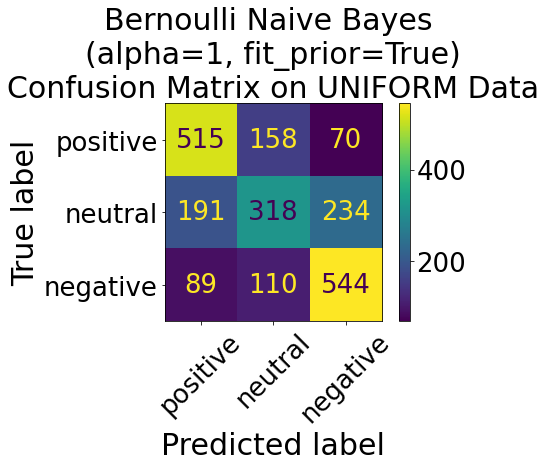

<Figure size 2304x1296 with 0 Axes>

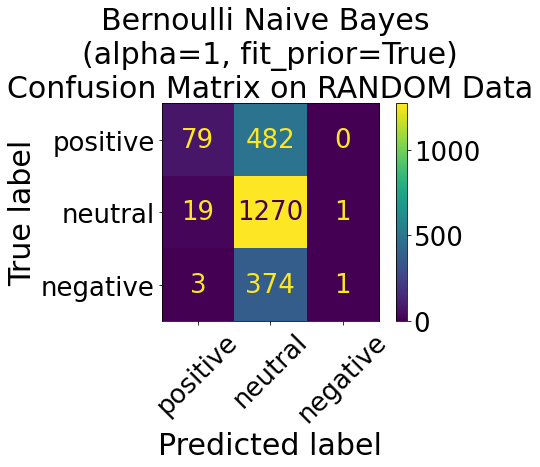

<Figure size 2304x1296 with 0 Axes>

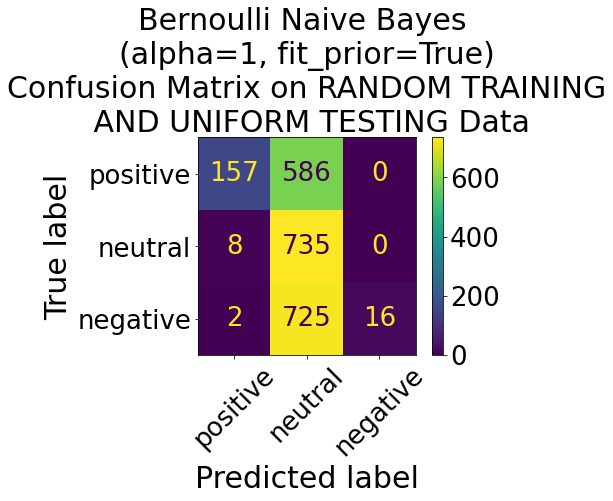

<Figure size 2304x1296 with 0 Axes>

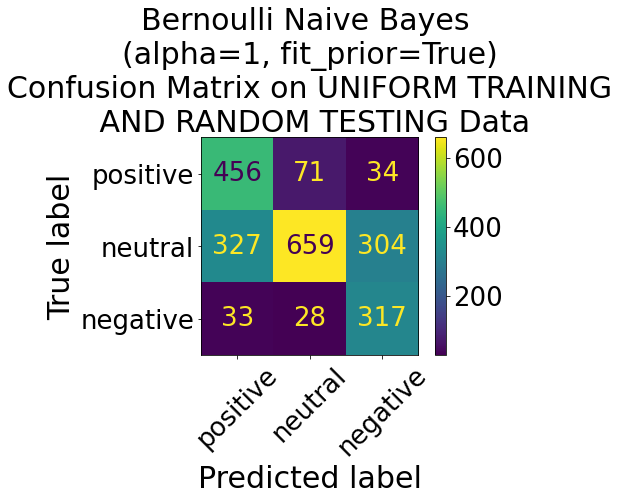

<Figure size 2304x1296 with 0 Axes>

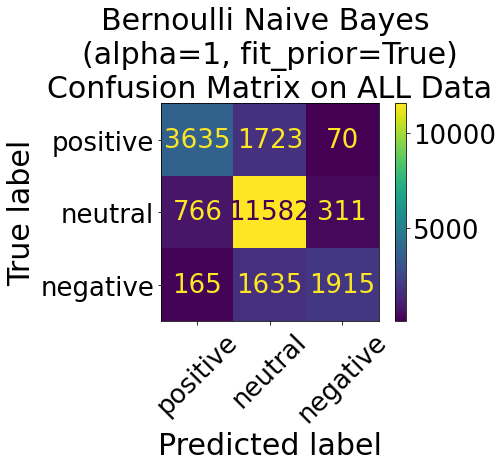

<Figure size 2304x1296 with 0 Axes>

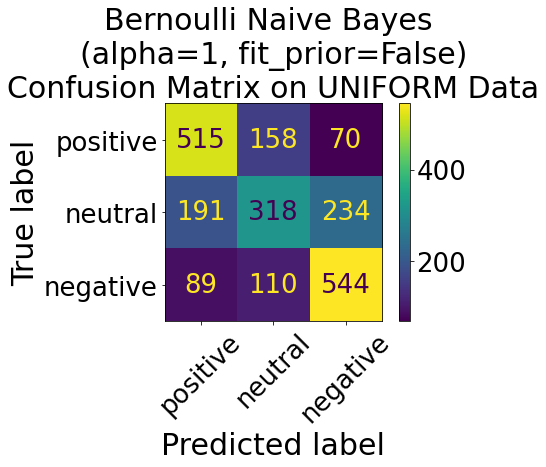

<Figure size 2304x1296 with 0 Axes>

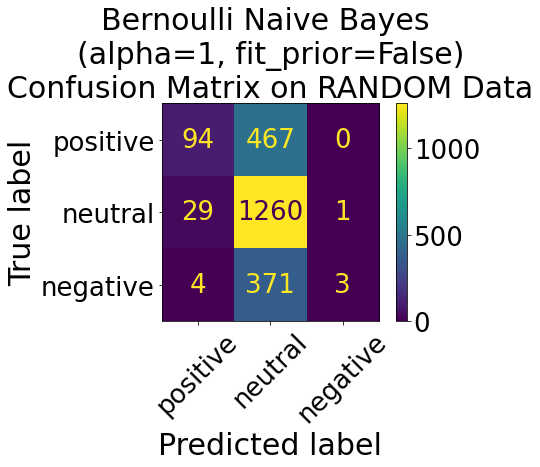

<Figure size 2304x1296 with 0 Axes>

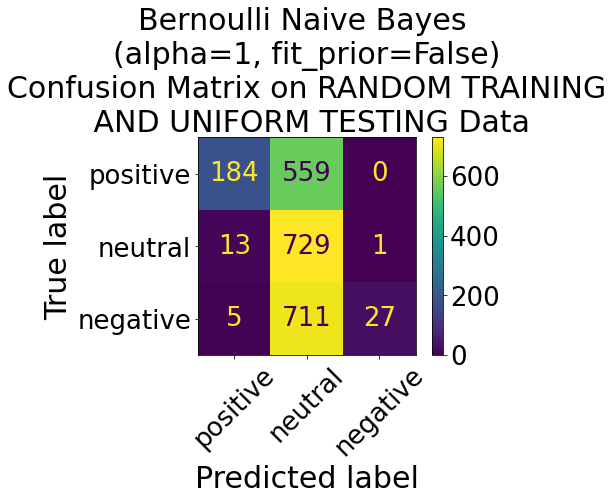

<Figure size 2304x1296 with 0 Axes>

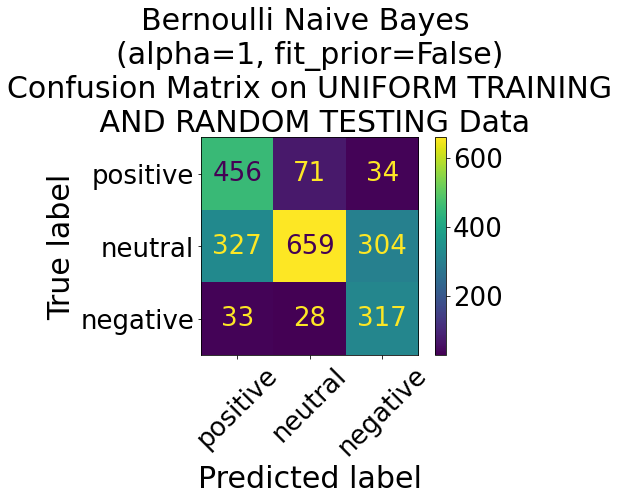

<Figure size 2304x1296 with 0 Axes>

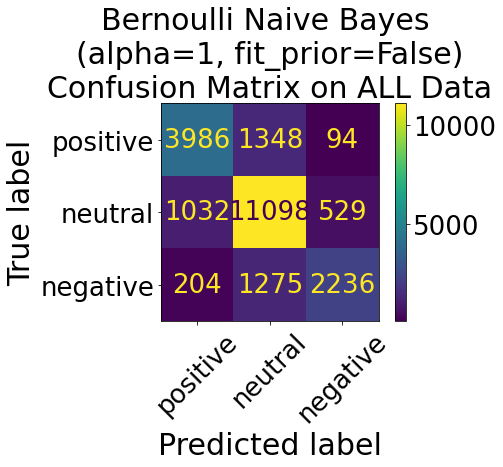

<Figure size 2304x1296 with 0 Axes>

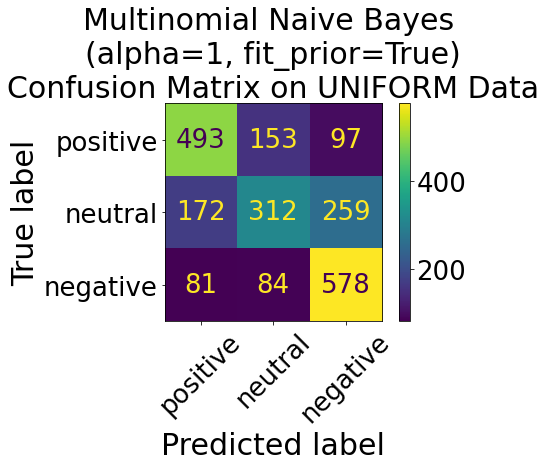

<Figure size 2304x1296 with 0 Axes>

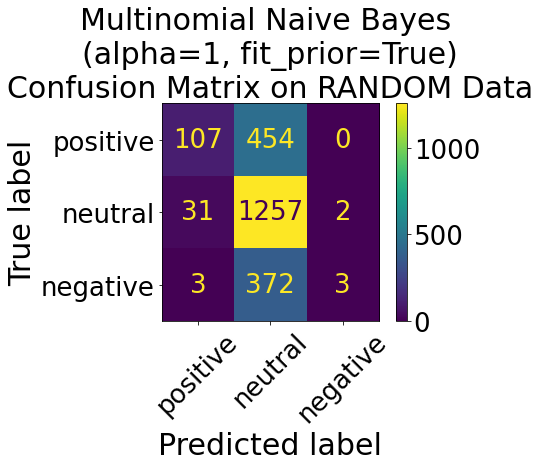

<Figure size 2304x1296 with 0 Axes>

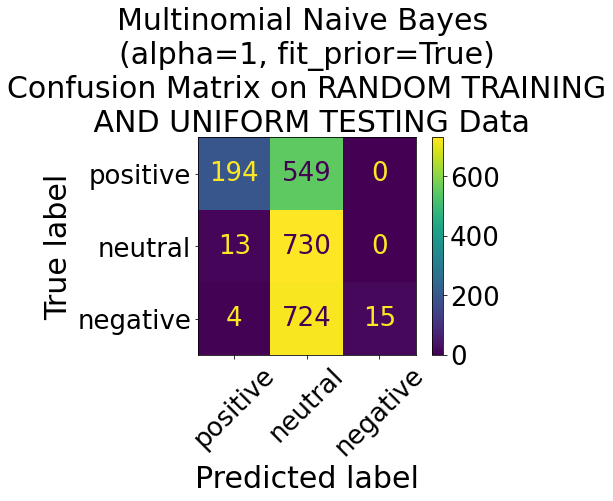

<Figure size 2304x1296 with 0 Axes>

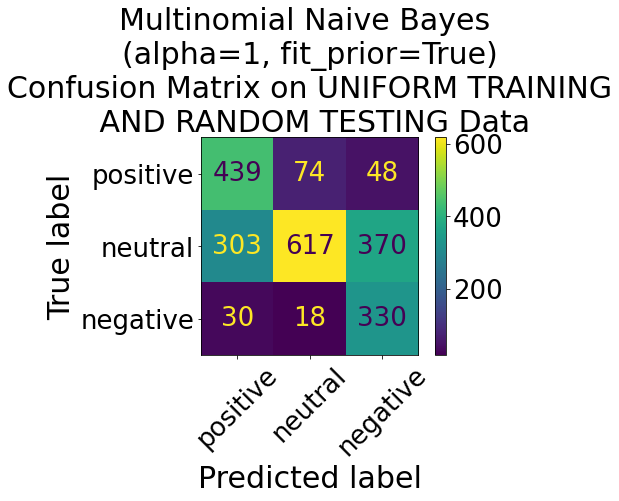

<Figure size 2304x1296 with 0 Axes>

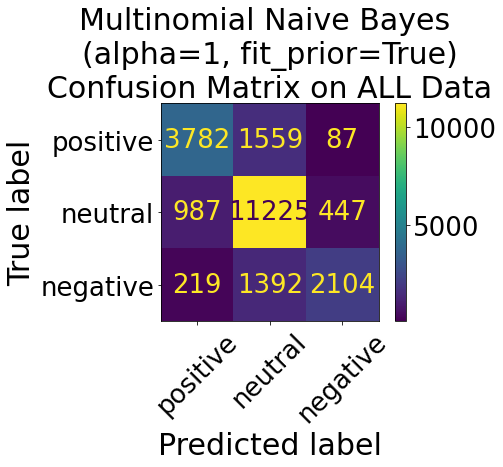

In [72]:
model_name = 'Bernoulli Naive Bayes \n(alpha=1, fit_prior=True)'
print(model_name)
model_1st = {}
# create the model
model_1st[TYPE_CLASSIFIER] = BernoulliNB(alpha=1, fit_prior=True)

# Evaluate the model
model_1st[TYPE_SCORES] = evaluate_score(model_1st[TYPE_CLASSIFIER], X_train, y)
pprint(model_1st[TYPE_SCORES])
model_1st[TYPE_EVALUATION] = evaluate(model_1st[TYPE_CLASSIFIER], X_train, y, model_name, display=True)

model_name = 'Bernoulli Naive Bayes \n(alpha=1, fit_prior=False)'
print(model_name)
model_2nd = {}
# create the model
model_2nd[TYPE_CLASSIFIER] = BernoulliNB(alpha=1, fit_prior=False)

# Evaluate the model
model_2nd[TYPE_SCORES] = evaluate_score(model_2nd[TYPE_CLASSIFIER], X_train, y)
pprint(model_2nd[TYPE_SCORES])
model_2nd[TYPE_EVALUATION] = evaluate(model_2nd[TYPE_CLASSIFIER], X_train, y, model_name, display=True)


model_name = 'Multinomial Naive Bayes \n(alpha=1, fit_prior=True)'
print(model_name)
model_3rd = {}
# create the model
model_3rd[TYPE_CLASSIFIER] = MultinomialNB(alpha=1, fit_prior=True)

# Evaluate the model
model_3rd[TYPE_SCORES] = evaluate_score(model_3rd[TYPE_CLASSIFIER], X_train, y)
pprint(model_3rd[TYPE_SCORES])
model_3rd[TYPE_EVALUATION] = evaluate(model_3rd[TYPE_CLASSIFIER], X_train, y, model_name, display=True)